In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", color_codes=True)
sns.set(font_scale=1.35, style="ticks") #set styling preferences
import statsmodels.api as sm
from scipy import stats
import math
from math import pi
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2,vq, whiten
import geopandas as gpd
import h5py
import boto.s3
import glob
import boto3
from zipfile import ZipFile
import shutil

In [3]:
# Show all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

#### Baseline

In [5]:
%%time
s3 = boto3.client("s3")
key = "pilates-outputs/sfbay-baseline-2022124/inexus/sfbay_baseline_default-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sfbase = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:4: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 33s
Wall time: 1min 33s


In [6]:
#%%time
#s3 = boto3.client("s3")
#key = "pilates-outputs/sfbay-baseline-2022124/beam/year-2020-iteration-2/ITERS/it.0/0.events.csv.gz"  #the path should be updated
#obj = s3.get_object(Bucket="beam-outputs", Key=key)
#events_base = pd.read_csv(obj['Body'], compression = 'gzip')

In [7]:
# Adding scenario info
sfbase['scenario'] = "baseline"
sfbase['scenario'] = sfbase['scenario'].astype("category")
sfbase['lever'] = "default"
sfbase['lever'] = sfbase['lever'].astype("category")
sfbase['year'] = 2018
sfbase['lever_position'] = 1

In [8]:
# Mapping BEAM and ASIM modes
conditions  = [(sfbase['mode_choice_actual_BEAM'] == 'walk')&(sfbase['trip_mode_AS_trips'] == 'WALK'),
               (sfbase['mode_choice_actual_BEAM'] == 'bike')&(sfbase['trip_mode_AS_trips'] == 'BIKE'),
               (sfbase['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sfbase['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sfbase['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov3')&(sfbase['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov3')&(sfbase['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sfbase['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sfbase['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov2')&(sfbase['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov2')&(sfbase['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK_COM'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail')&(sfbase['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail')&(sfbase['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail')&(sfbase['trip_mode_AS_trips'] == 'TAXI'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')&(sfbase['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sfbase['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sfbase['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sfbase['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sfbase['trip_mode_AS_trips'] == 'TAXI'),
       
               (sfbase['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sfbase['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sfbase['trip_mode_AS_trips'] == 'SHARED3PAY')|(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov2')&((sfbase['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sfbase['trip_mode_AS_trips'] == 'SHARED3FREE')|(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'car_hov3')&((sfbase['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sfbase['trip_mode_AS_trips'] == 'SHARED2FREE')|(sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sfbase['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sfbase['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sfbase['trip_mode_AS_trips'] == 'SHARED2PAY')|(sfbase['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'car')&((sfbase['trip_mode_AS_trips'] == 'SHARED3FREE')|(sfbase['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sfbase['trip_mode_AS_trips'] == 'SHARED3PAY')|(sfbase['trip_mode_AS_trips'] == 'SHARED2PAY')|(sfbase['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sfbase['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sfbase['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sfbase['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'walk')&((sfbase['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sfbase['trip_mode_AS_trips'] == 'WALK_LOC')|(sfbase['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sfbase['trip_mode_AS_trips'] == 'WALK_HVY')|(sfbase['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(sfbase['trip_mode_AS_trips'] == 'WALK'),
               
               ((sfbase['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sfbase['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sfbase['trip_mode_AS_trips'] == 'TAXI')|(sfbase['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sfbase['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sfbase['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sfbase['trip_mode_AS_trips'] == 'WALK_LOC')|(sfbase['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sfbase['trip_mode_AS_trips'] == 'WALK_HVY')|(sfbase['trip_mode_AS_trips'] == 'WALK_COM')|
               (sfbase['trip_mode_AS_trips'] == 'WALK'))),
               
               (sfbase['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sfbase['mode_choice_actual_BEAM'] == 'car')&((sfbase['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sfbase['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sfbase['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sfbase['WALK'], sfbase['BIKE'], sfbase['SHARED3FREE'], sfbase['SHARED3PAY'],
           sfbase['SHARED3FREE'], sfbase['SHARED3PAY'], sfbase['SHARED2FREE'], 
           sfbase['SHARED2PAY'], sfbase['SHARED2PAY'], sfbase['SHARED2FREE'], 
           sfbase['DRIVEALONEFREE'], sfbase['DRIVEALONEPAY'], sfbase['WALK_LRF'], 
           sfbase['WALK_LOC'], sfbase['WALK_EXP'], sfbase['WALK_HVY'], sfbase['WALK_COM'],
           sfbase['TNC_SINGLE'], 
           sfbase['TNC_SHARED'], sfbase['TAXI'],
           sfbase['DRIVE_COM'], sfbase['DRIVE_LRF'], sfbase['DRIVE_LOC'], sfbase['DRIVE_EXP'],
           sfbase['DRIVE_HVY'], sfbase['TNC_SINGLE'], sfbase['TNC_SHARED'], sfbase['TAXI'],
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sfbase[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sfbase[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sfbase[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [9]:
sfbase['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [10]:
sfbase['Realized_INEXUS'] = np.where((sfbase['Realized_INEXUS'].isna())&((sfbase['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'car')|
                                          (sfbase['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sfbase[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sfbase['Realized_INEXUS'])

In [11]:
sfbase['Realized_INEXUS'] = np.where((sfbase['Realized_INEXUS'].isna())&((sfbase['mode_choice_actual_BEAM'] == 'walk')|
                                         (sfbase['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                          sfbase[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sfbase['Realized_INEXUS'])

In [12]:
sfbase['Realized_INEXUS'] = np.where(sfbase['Realized_INEXUS'].isna()&(sfbase['mode_choice_actual_BEAM'] == 'bike'), 
                                         sfbase[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sfbase['Realized_INEXUS'])

In [13]:
sfbase[sfbase['Realized_INEXUS'].isna()].shape

(19191, 274)

In [14]:
# dropping the rows with NAN utility values 
sfbase.dropna(subset=['Realized_INEXUS'], inplace=True)

In [15]:
# remove the outliers
sfbase = sfbase[(sfbase['duration_travelling'] > 0)].reset_index(drop=True)

In [16]:
conditions  = [(sfbase['primary_purpose_x'] == 'work'),(sfbase['primary_purpose_x'] == 'univ'),
               (sfbase['primary_purpose_x'] == 'school'),(sfbase['primary_purpose_x'] == 'escort'),
              (sfbase['primary_purpose_x'] == 'shopping'),(sfbase['primary_purpose_x'] == 'eatout'),
              (sfbase['primary_purpose_x'] == 'othmaint'),(sfbase['primary_purpose_x'] == 'social'),
              (sfbase['primary_purpose_x'] == 'othdiscr'),(sfbase['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [17]:
sfbase['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [18]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sfbase['alpha'] = -0.6 *(sfbase['c_ivt'])/(sfbase['value_of_time'])

CPU times: total: 125 ms
Wall time: 23.4 ms


In [19]:
sfbase['Realized_INEXUS_in_dollar_2023'] = ((sfbase['Realized_INEXUS']/sfbase['alpha'])/100)*1.75

In [20]:
sfbase['Potential_INEXUS_in_dollar_2023'] = ((sfbase['logsum_trip_Potential_INEXUS']/sfbase['alpha'])/100)*1.75

In [254]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sfbase[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sfbase['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sfbase_clean_ml = sfbase[sfbase['is_outlier'] == 1]

In [257]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sfbase[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023', 'duration_walking']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sfbase['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sfbase_clean_ml_walk = sfbase[sfbase['is_outlier'] == 1]

(2216377, 279)

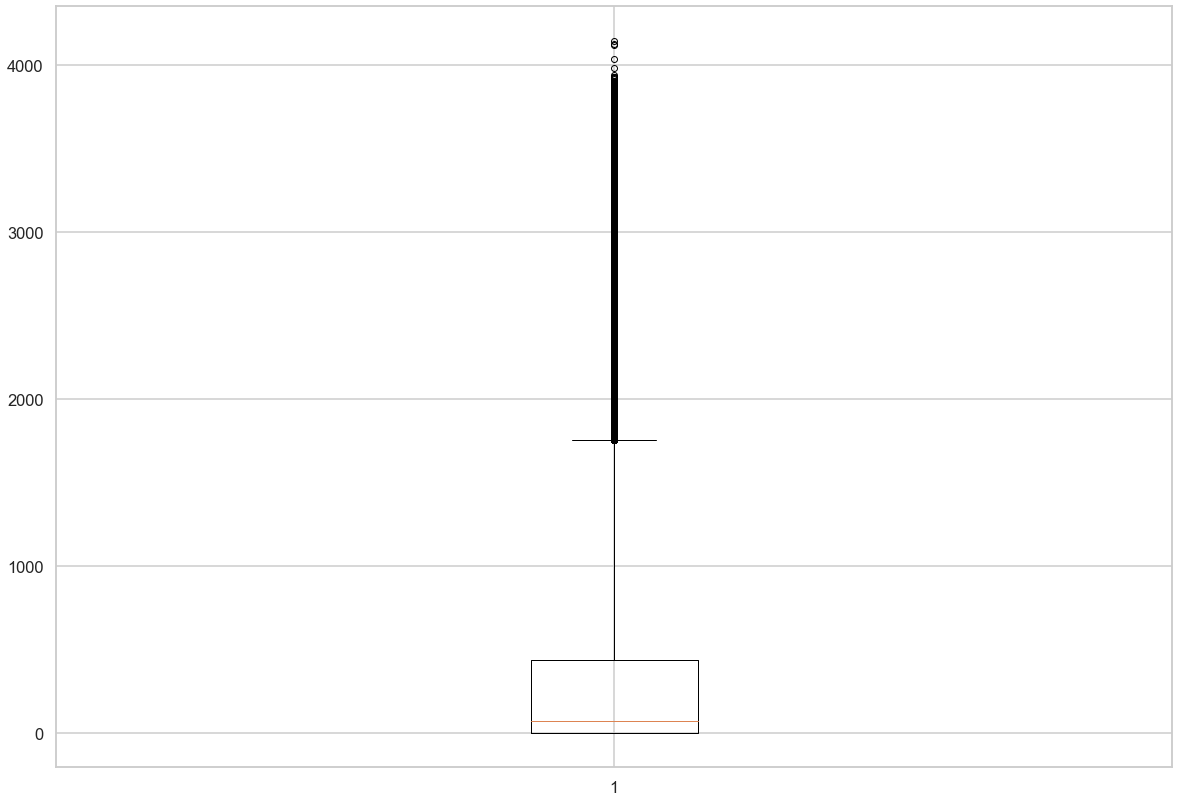

In [258]:
plt.boxplot(sfbase_clean_ml_walk['duration_walking'], whis=3)
plt.show()

In [24]:
sfbase_clean_ml.shape

(2216377, 279)

In [25]:
sfbase_clean_ml.Realized_INEXUS_in_dollar_2023.describe()

count   2216377.000000
mean         -7.258542
std           8.680961
min         -53.312728
25%         -10.714531
50%          -5.028735
75%          -2.018444
max          15.434692
Name: Realized_INEXUS_in_dollar_2023, dtype: float64

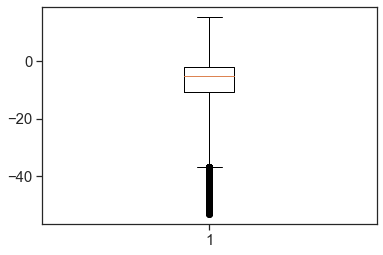

In [26]:
plt.boxplot(sfbase_clean_ml['Realized_INEXUS_in_dollar_2023'], whis=3)
plt.show()

In [29]:
#sfbase_clean_iqr.shape

In [40]:
#sfbase_clean_iqr.Realized_INEXUS_in_dollar_2023.describe()

In [41]:
#plt.boxplot(sfbase_clean_iqr['Realized_INEXUS_in_dollar_2023'], whis=3)
#plt.show()

In [42]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sfbase['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sfbase['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sfbase_clean_iqr = sfbase[(sfbase['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sfbase['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sfbase['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sfbase['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

In [44]:
#sfbase_cleaned.Potential_INEXUS_in_dollar_2023.describe()

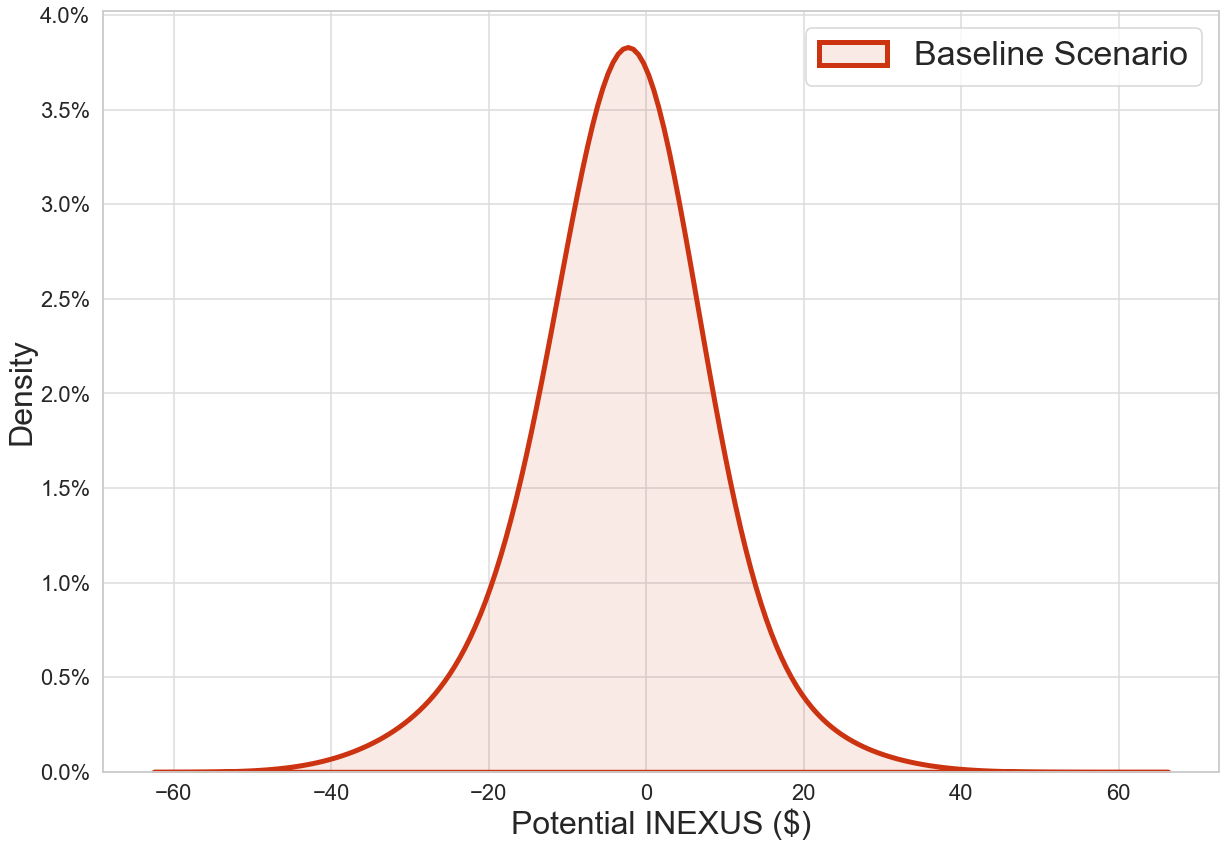

In [259]:
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

ax=sns.kdeplot(data=sfbase_clean_ml_walk, x="Potential_INEXUS_in_dollar_2023", 
            fill=True, alpha=0.1, color="#CC3311", bw_adjust =15, linewidth =5)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)
plt.legend(labels = ['Baseline Scenario'],
          fontsize='small', fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

#plt.xlim(-80, 70)
plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Baseline Scenario'], loc="best", fontsize=34),), bbox_inches='tight')
plt.savefig('density_baseline.png', bbox_extra_artists=(ax.legend(['Baseline Scenario'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 300)

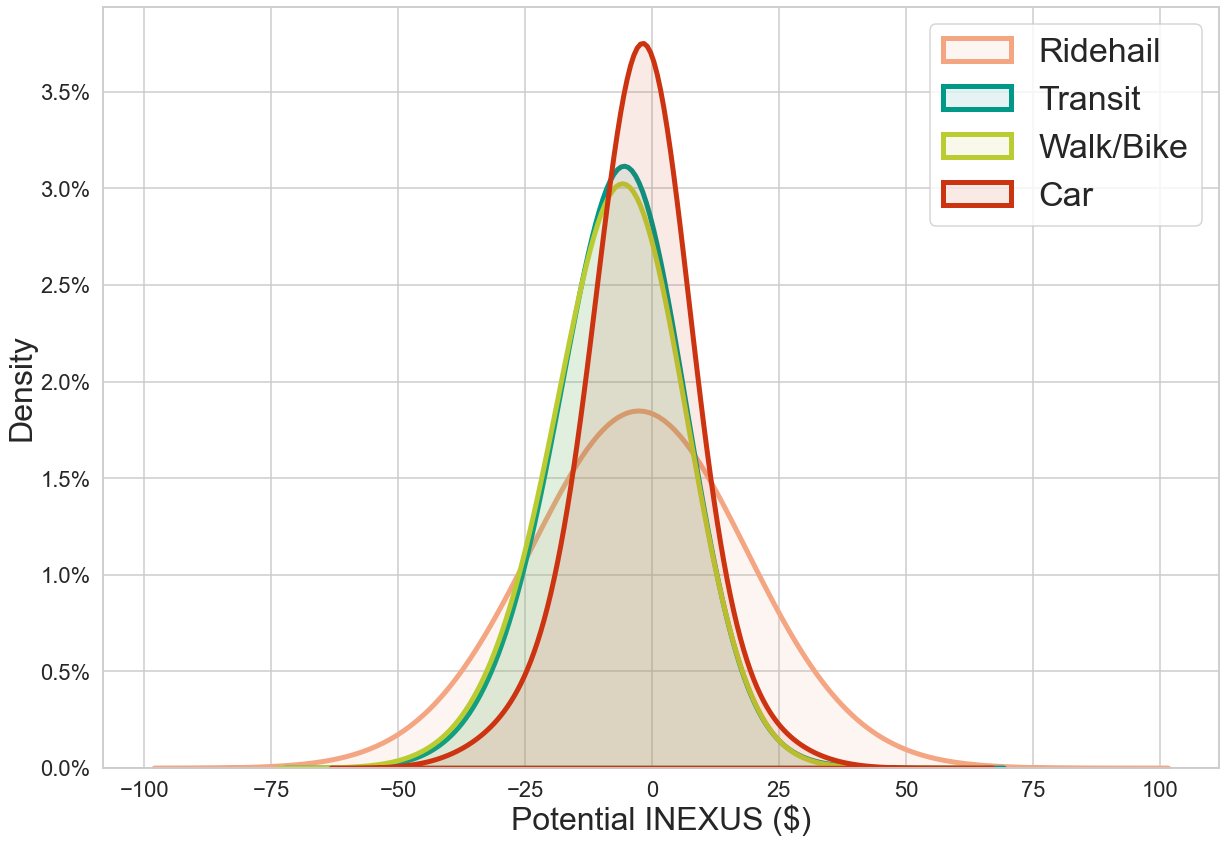

In [260]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
color_dict = {'walk/bike': '#CC3311', 'car': '#BBCC33', 'transit': '#009988', 'ride_hail': '#F4A582'} 

ax=sns.kdeplot(data=sfbase_clean_ml_walk, x="Potential_INEXUS_in_dollar_2023", hue = 'mode_choice_actual_4', 
            fill=True, common_norm=False, common_grid = False, palette=color_dict.values(), alpha=0.1, bw_adjust =15, linewidth =5)  #color_dict.values()
#sns.color_palette('rocket_r', n_colors=4) #palette=color_dict.values()
#rainbow_r  tab20
#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#plt.xlim(-130, 130)

plt.legend(labels = ['Ridehail', 'Transit', 'Walk/Bike', 'Car'],
          fontsize='small', fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_mode_baseline.svg', bbox_extra_artists=(ax.legend( ['Ridehail', 'Transit', 'Walk/Bike', 'Car'], loc="best", fontsize=34),), bbox_inches='tight')
plt.savefig('density_mode_baseline.png', bbox_extra_artists=(ax.legend( ['Ridehail', 'Transit', 'Walk/Bike', 'Car'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 300)

In [50]:
# Add the mandatory category column
mandatory = ['work' , 'univ', 'school']
sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(mandatory)) & (sfbase_clean_ml.actStartType.isin(mandatory)), 'from_M_to_M' , None)

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_10752\883267117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(mandatory)) & (sfbase_clean_ml.actStartType.isin(mandatory)), 'from_M_to_M' , None)


In [51]:
sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType == 'Home') & (sfbase_clean_ml.actStartType.isin(mandatory)), 'from_H_to_M' , sfbase_clean_ml['mandatoryCat'])

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_10752\3613086050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType == 'Home') & (sfbase_clean_ml.actStartType.isin(mandatory)), 'from_H_to_M' , sfbase_clean_ml['mandatoryCat'])


In [52]:
sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(mandatory)) & (sfbase_clean_ml.actStartType == "Home"), 'from_M_to_H' , sfbase_clean_ml['mandatoryCat'])

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_10752\3753784467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(mandatory)) & (sfbase_clean_ml.actStartType == "Home"), 'from_M_to_H' , sfbase_clean_ml['mandatoryCat'])


In [53]:
non_mandatory = ['othmaint' , 'othdiscr', 'escort', 'eatout', 'social', 'shopping', 'atwork']
sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(non_mandatory)) & (sfbase_clean_ml.actStartType.isin(non_mandatory)), 'from_N_to_N' , sfbase_clean_ml['mandatoryCat'])

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_10752\2972594462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfbase_clean_ml['mandatoryCat'] = np.where((sfbase_clean_ml.actEndType.isin(non_mandatory)) & (sfbase_clean_ml.actStartType.isin(non_mandatory)), 'from_N_to_N' , sfbase_clean_ml['mandatoryCat'])


In [54]:
sfbase_clean_ml['mand_cat'] = np.where(sfbase_clean_ml['mandatoryCat'].isin(['from_M_to_M', 'from_M_to_H', 'from_H_to_M']), 'mand', 'non-mand')

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_10752\3720449072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfbase_clean_ml['mand_cat'] = np.where(sfbase_clean_ml['mandatoryCat'].isin(['from_M_to_M', 'from_M_to_H', 'from_H_to_M']), 'mand', 'non-mand')


In [55]:
sfbase_clean_ml.groupby('mand_cat')['Potential_INEXUS_in_dollar_2023'].describe()

,count,mean,std,min,25%,50%,75%,max
mand_cat,,,,,,,,
mand,681373.000000,-7.258650,7.588162,-30.380955,-11.286466,-5.644793,-2.212408,27.386846
non-mand,1535004.000000,-1.463560,7.557577,-30.380765,-4.613437,-1.236580,2.158989,27.229892


C:\Users\nrezaei\anaconda3\envs\BEAM-CORE\lib\site-packages\seaborn\utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


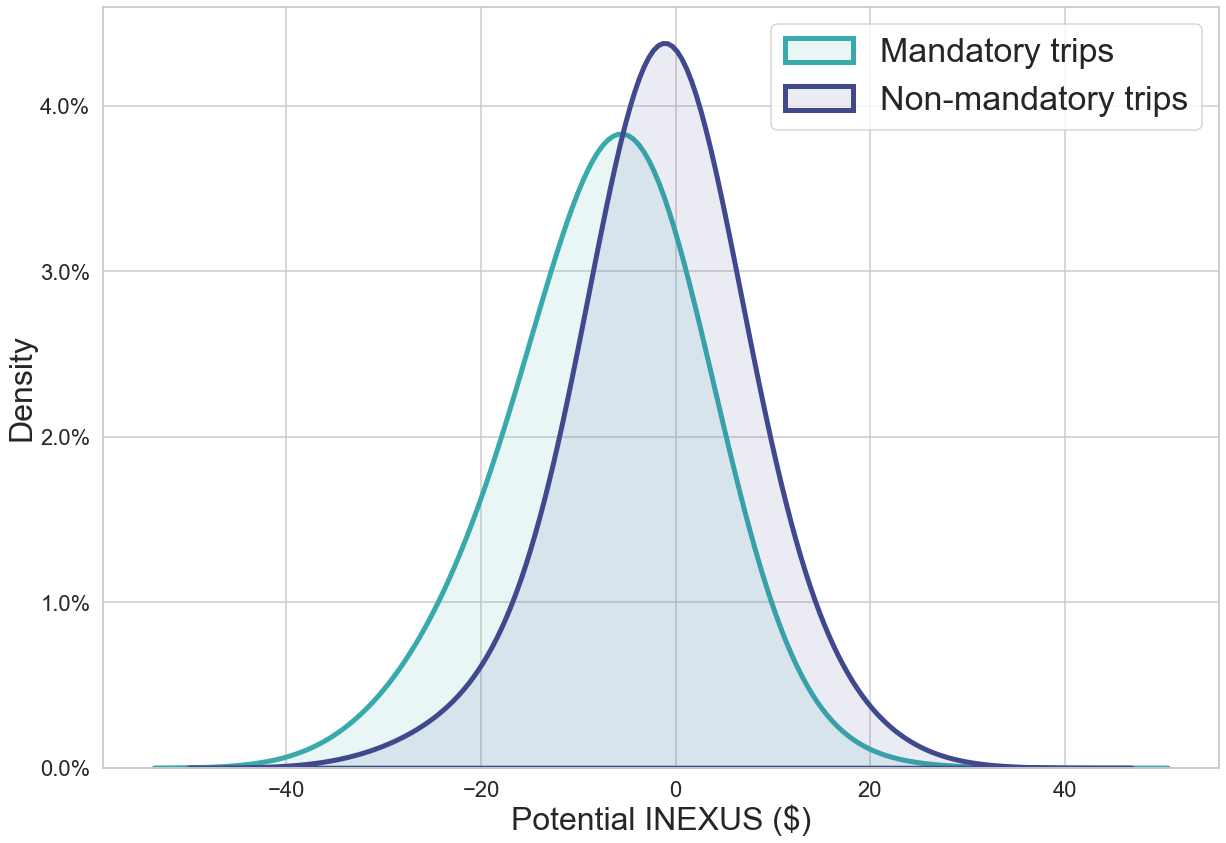

In [56]:
sns.set(rc={'figure.figsize':(20,14)}) #
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=sfbase_clean_ml, x="Potential_INEXUS_in_dollar_2023", hue = 'mand_cat',
            fill=True, common_norm=False, alpha=0.1, palette=sns.color_palette('mako', n_colors=2), bw_adjust =15, linewidth =5)
sns.move_legend(ax, labels = ['Mandatory trips','Non-mandatory trips'], loc="best", ncol=1, title=None, frameon=True, fontsize = 28)#, bbox_to_anchor=(1.25, 0.6), 

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#plt.xlim(-90, 75)
plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_mand_baseline.svg', bbox_extra_artists=(ax.legend(['Mandatory trips','Non-mandatory trips'], loc="best", fontsize=28),), bbox_inches='tight')
plt.savefig('density_mand_baseline.png', bbox_extra_artists=(ax.legend(['Mandatory trips','Non-mandatory trips'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 300)

In [57]:
# get the quartiles of the distance column
quartiles = np.percentile(sfbase_clean_ml['distance_travelling'], [25, 50, 75])

# set the cutoffs based on the quartiles
cutoffs = [0, quartiles[0], quartiles[1], quartiles[2], float('inf')]

# label the distances based on the cutoffs
sfbase_clean_ml['distance_group'] = pd.qcut(sfbase_clean_ml['distance_travelling'], q=3, labels=['short', 'medium', 'long'])

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_10752\2584001480.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfbase_clean_ml['distance_group'] = pd.qcut(sfbase_clean_ml['distance_travelling'], q=3, labels=['short', 'medium', 'long'])


In [58]:
# Add a column of income deciles
deciles = sfbase_clean_ml['distance_travelling'].quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()

In [59]:
# Add distance_travelling deciles
conditions  = [(sfbase_clean_ml['distance_travelling'] >= deciles[0]) & (sfbase_clean_ml['distance_travelling'] < deciles[1]), 
               (sfbase_clean_ml['distance_travelling'] >= deciles[1]) & (sfbase_clean_ml['distance_travelling'] < deciles[2]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[2]) & (sfbase_clean_ml['distance_travelling'] < deciles[3]),
               (sfbase_clean_ml['distance_travelling'] >= deciles[3]) & (sfbase_clean_ml['distance_travelling'] < deciles[4]), 
               (sfbase_clean_ml['distance_travelling'] >=  deciles[4]) & (sfbase_clean_ml['distance_travelling'] < deciles[5]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[5]) & (sfbase_clean_ml['distance_travelling'] < deciles[6]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[6]) & (sfbase_clean_ml['distance_travelling'] < deciles[7]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[7]) & (sfbase_clean_ml['distance_travelling'] < deciles[8]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[8]) & (sfbase_clean_ml['distance_travelling'] < deciles[9]),
               (sfbase_clean_ml['distance_travelling'] >=  deciles[9]) & (sfbase_clean_ml['distance_travelling'] <= deciles[10])]

choices = [ '1stD', '2ndD', '3rdD', 
           '4thD', '5thD', '6thD', '7thD', '8thD', '9thD','10thD']

In [60]:
sfbase_clean_ml['distance_deciles'] = np.select(conditions, choices, default=None)

C:\Users\nrezaei\AppData\Local\Temp\2\ipykernel_10752\2193146414.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfbase_clean_ml['distance_deciles'] = np.select(conditions, choices, default=None)


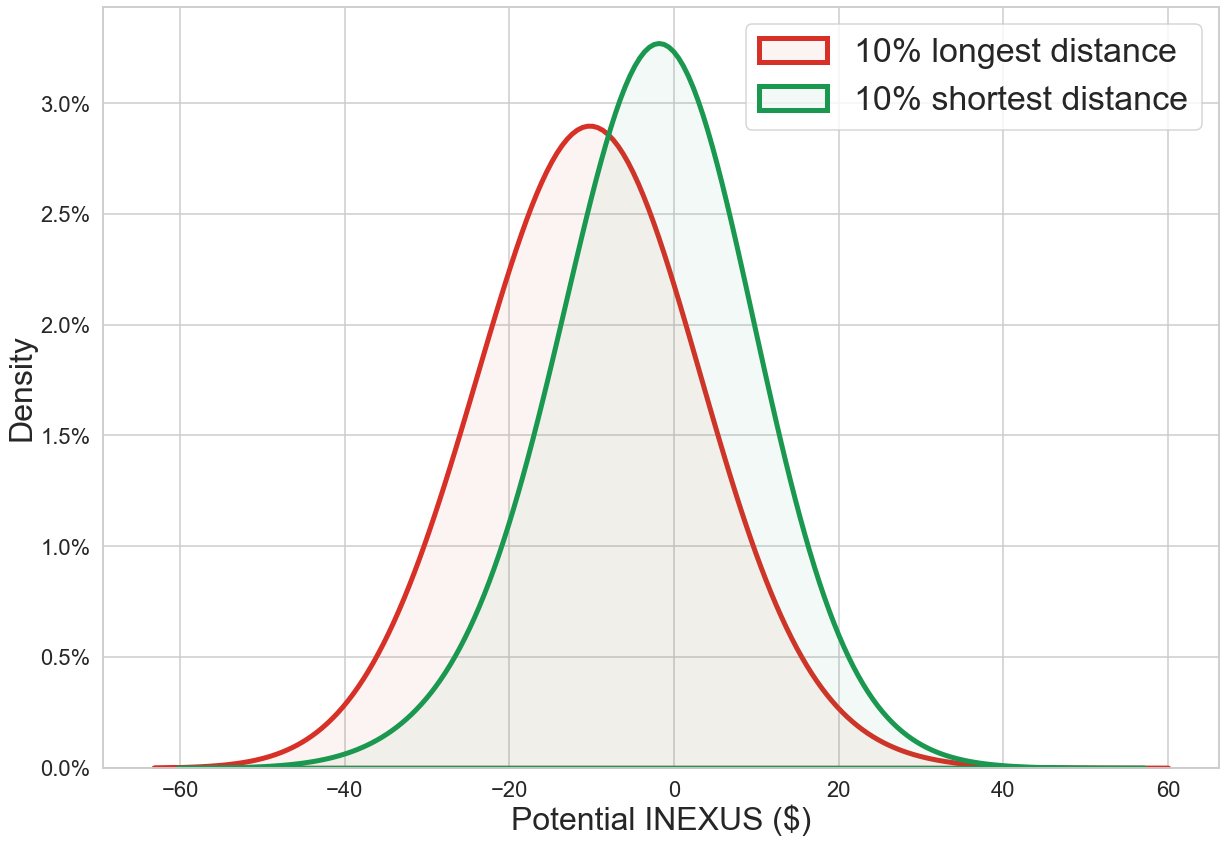

In [61]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
colors = ["#1a9850", "#d73027", "#FFA07A", "#b3de69"] 

#color_dict = {'walk/bike': '#CC3311', 'car': '#BBCC33', 'transit': '#009988', 'ride_hail': '#F4A582'} 
sns.set_palette(sns.color_palette(colors))

ax=sns.kdeplot(data=sfbase_clean_ml[(sfbase_clean_ml['distance_deciles'] == '1stD')|(sfbase_clean_ml['distance_deciles'] == '10thD')]
                                    , x="Potential_INEXUS_in_dollar_2023", hue = 'distance_deciles', 
            fill=True, common_norm=False, common_grid = False,alpha=0.05, bw_adjust =15, linewidth =5)  #color_dict.values()
#sns.color_palette('rocket_r', n_colors=4) #palette=color_dict.values()
#rainbow_r  tab20
#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

# Define function to format y-axis labels as percentages
def to_percent(y, position):
    return "{:.1f}%".format(y * 100)

# Format y-axis labels as percentages
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

#plt.xlim(-120, 100)

plt.legend(labels = ['10% longest distance','10% shortest distance'],
        fontsize='small', title_fontsize = 30, fancybox=False, ncol=1, frameon=True, loc = 'best', prop={'size': 32}) #title="Modes" #bbox_to_anchor=(1.5, 0.7), 

plt.xlabel('Potential INEXUS ($)', fontsize=32)
plt.ylabel('Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
plt.savefig('density_baseline_distance.svg', bbox_extra_artists=(ax.legend(['10% longest distance','10% shortest distance'], loc="best", fontsize=34),), bbox_inches='tight')
plt.savefig('density_baseline_distance.png', bbox_extra_artists=(ax.legend(['10% longest distance','10% shortest distance'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 300)

#### Extra checks

In [ ]:
conditions  = [(sfbase['primary_purpose_x'] == 'work'),(sfbase['primary_purpose_x'] == 'univ'),
               (sfbase['primary_purpose_x'] == 'school'),(sfbase['primary_purpose_x'] == 'escort'),
              (sfbase['primary_purpose_x'] == 'shopping'),(sfbase['primary_purpose_x'] == 'eatout'),
              (sfbase['primary_purpose_x'] == 'othmaint'),(sfbase['primary_purpose_x'] == 'social'),
              (sfbase['primary_purpose_x'] == 'othdiscr'),(sfbase['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [ ]:
sfbase['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [ ]:
sfbase['value_of_time'].describe()

In [ ]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sfbase['alpha'] = - 0.6 *(sfbase['c_ivt'])/(sfbase['value_of_time'])

In [ ]:
sfbase['Potential_INEXUS_in_dollar'] = ((sfbase['logsum_trip_Potential_INEXUS']/sfbase['alpha'])/100)

In [ ]:
sfbase['Potential_INEXUS_in_dollar_2023'] = ((sfbase['logsum_trip_Potential_INEXUS']/sfbase['alpha'])/100)*1.75

In [ ]:
sfbase['Potential_INEXUS_in_dollar'].describe()

In [ ]:
sfbase['Potential_INEXUS_in_dollar_2023'].describe()

In [ ]:
sfbase[sfbase.income_deciles.isna()].shape[0]

In [ ]:
sfbase.dropna(subset=['income'], inplace=True)

In [ ]:
# remove the outliers
sfbase_cleaned = sfbase[(sfbase['distance_walking']< 5000)&
                        (sfbase['duration_walking'] < 3600)&
                        (sfbase['duration_travelling']>0)]

In [ ]:
sfbase_cleaned[sfbase_cleaned['Potential_INEXUS_in_dollar_2023']<-100].shape

In [ ]:
sfbase_cleaned_rm_ouliers = sfbase_cleaned[(sfbase_cleaned['Potential_INEXUS_in_dollar_2023']>-10)&
                                          (sfbase_cleaned['Potential_INEXUS_in_dollar_2023']<5)]

In [ ]:
sns.set(rc={'figure.figsize':(15,7)})
plt.hist(sfbase_cleaned_rm_ouliers['Potential_INEXUS_in_dollar_2023'],bins=100, color='blue', edgecolor='black')

# Add axis labels and title
plt.xlabel('Potential INEXUS in Dollar')
plt.ylabel('Frequency')
plt.title('Distribution of Potential INEXUS in Dollar')

# Show the plot
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

ax=sns.kdeplot(data=sfbase_cleaned_rm_ouliers, x="Potential_INEXUS_in_dollar_2023", 
            fill=True, common_norm=False, common_grid = False, alpha=0.1, color="#CC3311", bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

ax=sns.kdeplot(data=sfbase_cleaned_rm_ouliers[(sfbase_cleaned_rm_ouliers['income_deciles']=='1stD')|(sfbase_cleaned_rm_ouliers['income_deciles']=='10thD')], x="logsum_trip_Potential_INEXUS", 
            hue = 'income_deciles',fill=True, common_norm=False, common_grid = False, alpha=0.1, color="#CC3311", bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Highest 10% Income','Lowest 10% Income'], loc="best", ncol=1, title=None, frameon=True, fontsize = 36) #bbox_to_anchor=(1.25, 0.6)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid",{'grid.color': 'gainsboro'}) 
#'whitesmoke': a very light grey color with a hint of blue.
#'gainsboro': a very light grey color with a hint of blue-green.
#'lightgray': a slightly lighter shade of grey than 'lightgrey'.
#'lavender'

ax=sns.kdeplot(data=sfbase_cleaned_rm_ouliers[(sfbase_cleaned_rm_ouliers['income_deciles']=='1stD')|(sfbase_cleaned_rm_ouliers['income_deciles']=='10thD')], x="Potential_INEXUS_in_dollar", 
            hue = 'income_deciles',fill=True, common_norm=False, common_grid = False, alpha=0.1, color="#CC3311", bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Highest 10% Income','Lowest 10% Income'], loc="best", ncol=1, title=None, frameon=True, fontsize = 36) #bbox_to_anchor=(1.25, 0.6)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sfbase_cleaned_plot[sfbase_cleaned_plot['income_deciles']=='1stD'].describe()

In [ ]:
sfbase_cleaned_plot[sfbase_cleaned_plot['income_deciles']=='10thD'].describe()

In [32]:
sfbase_cleaned_plot['car_nocar'] = np.where(sfbase_cleaned_plot['auto_ownership'] == 0, "nocar", "car")

NameError: name 'sfbase_cleaned_plot' is not defined

In [ ]:
sfbase_cleaned_plot[sfbase_cleaned_plot['car_nocar']=='car'].describe()

In [ ]:
sfbase_cleaned_plot[sfbase_cleaned_plot['car_nocar']=='nocar'].describe()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')

sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})

ax=sns.kdeplot(data=sfbase_cleaned_plot, x="Potential_INEXUS_in_dollar_2023", hue = 'car_nocar',
            fill=True, common_norm=False, alpha=0.05,bw_adjust =12, linewidth =5)

#sns.move_legend(ax, labels = ['Lowest 10% Income','Highest 10% Income'], loc="right", bbox_to_anchor=(1.25, 0.6), ncol=1, title=None, frameon=True)

#plt.xlim(-100, 100)
plt.xlabel('Potential INEXUS in dollar', fontsize=32)
plt.ylabel('Frequency Density', fontsize=32)
ax.yaxis.set_tick_params(labelsize = 22)
ax.xaxis.set_tick_params(labelsize = 22)
#plt.savefig('baseline_mand.svg', format='svg')
#plt.savefig('density_baseline.svg', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight')
#plt.savefig('density_income_baseline.png', bbox_extra_artists=(ax.legend(['Lowest 10% Income','Highest 10% Income'], loc="best", fontsize=34),), bbox_inches='tight', dpi = 1000)

In [ ]:
sfbase['distance_walking'].mean()

In [ ]:
sfbase['duration_walking'].mean()

In [ ]:
sfbase[sfbase['distance_walking'] > 15000].head()

In [ ]:
len(sfbase[(sfbase['mode_choice_actual_BEAM'] == 'walk') & (sfbase['duration_walking'] < 3600)])

In [ ]:
len(sfbase[(sfbase['mode_choice_actual_BEAM'] != 'walk') & (sfbase['duration_walking'] > 3600)])

In [ ]:
sfbase[(sfbase['mode_choice_actual_BEAM'] != 'walk') & (sfbase['duration_walking'] > 3600)].head()

In [ ]:
len(sfbase[sfbase['mode_choice_actual_BEAM'] == 'walk'])

In [ ]:
len(sfbase[sfbase['duration_walking'] > 3600])

In [ ]:
sfbase.shape

In [33]:
sfbase[sfbase['mode_choice_actual_BEAM'] == 'walk']['duration_walking'].mean()

2924.3189760260057

In [34]:
#sfbase_cleaned = sfbase[~((sfbase['mode_choice_actual_BEAM'] == 'walk') & (sfbase['duration_walking'] >= 3600))]

In [35]:
sfbase_cleaned_final = sfbase[(sfbase['duration_walking'] < 3600)&(sfbase['distance_walking']< 5000)
                               &(sfbase['duration_travelling']>0)]

In [36]:
sfbase_cleaned_final.shape

(2378573, 279)

In [37]:
sfbase.shape 

(2462642, 279)

In [38]:
sfbase_cleaned_final.head()

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,vehicleIds_estimate,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_num,outbound,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_type_count,tour_type_num,tour_num,tour_count,tour_category,number_of_participants,destination_y,origin_y,household_id_x,tdd,start,end,duration,composition,destination_logsum_y,tour_mode_AS_tours,logsum_tours_mode_AS_tours,atwork_subtour_frequency,parent_tour_id,stop_frequency,primary_purpose_y,age,earning,edu,hispanic,hours,PNUM,race_id,relate,sex,student,work_at_home,worker,household_id_y,person_age,person_sex,race,hispanic.1,p_hispanic,MAR,TAZ_x,ptype,pemploy,pstudent,home_x,home_y,age_16_to_19,age_16_p,adult,male,female,has_non_worker,has_retiree,has_preschool_kid,has_driving_kid,has_school_kid,has_full_time,has_part_time,has_university,student_is_employed,nonstudent_to_school,is_student,is_gradeschool,is_highschool,is_university,school_segment,is_worker,home_taz,value_of_time,school_taz,distance_to_school,roundtrip_auto_time_to_school,workplace_taz,workplace_location_logsum,distance_to_work,workplace_in_cbd,work_taz_area_type,roundtrip_auto_time_to_work,work_auto_savings,work_auto_savings_ratio,free_parking_at_work,cdap_activity,travel_active,under16_not_at_school,has_preschool_kid_at_home,has_school_kid_at_home,mandatory_tour_frequency,work_and_school_and_worker,work_and_school_and_student,num_mand,num_work_tours,num_joint_tours,non_mandatory_tour_frequency,num_non_mand,num_escort_tours,num_eatout_tours,num_shop_tours,num_maint_tours,num_discr_tours,num_social_tours,num_non_escort_tours,serialno,VEHICL,income,race_of_head,age_of_head,num_workers,hispanic_status_of_head,tenure,recent_mover,sf_detached,hh_age_of_head,hh_race_of_head,hispanic_head,hh_size,hh_cars,hh_children,seniors,hh_income,hh_workers,tenure_mover,hh_seniors,block_id,lcm_county_id,hhsize,gt55,gt2,hh_type,TAZ_y,HHT,sample_rate,chunk_id,income_in_thousands,income_segment,median_value_of_time,hh_value_of_time,num_non_workers,num_drivers,num_adults,num_children,num_young_children,num_children_5_to_15,num_children_16_to_17,num_college_age,num_young_adults,non_family,family,home_is_urban,home_is_rural,auto_ownership,hh_work_auto_savings_ratio,num_under16_not_at_school,num_travel_active,num_travel_active_adults,num_travel_active_preschoolers,num_travel_active_children,num_travel_active_non_preschoolers,participates_in_jtf_model,joint_tour_frequency,num_hh_joint_tours,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles,scenario,lever,year,lever_position,Realized_INEXUS,c_ivt,alpha,Realized_INEXUS_in_dollar_2023,Potential_INEXUS_in_dollar_2023,is_outlier
0,4,1513,56512.000000,56329.000000,183.000000,0.409358,othdiscr,Home,0.000000,183.000000

In [39]:
sfbase_cleaned_final.groupby('mode_choice_actual_BEAM')['marginal_emission'].sum()

KeyError: 'Column not found: marginal_emission'

In [ ]:
sfbase_cleaned_final[sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'hov3_teleportation']['distance_travelling'].mean()

In [ ]:
sfbase_cleaned_final[(sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'car')&(sfbase_cleaned_final['fuelGasoline']>0)&
                    (sfbase_cleaned_final['fuelDiesel']==0)&(sfbase_cleaned_final['fuelBiodiesel']==0)]['distance_travelling'].sum()

In [ ]:
len(sfbase_cleaned_final[sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'car'])

In [ ]:
len(sfbase_cleaned_final[(sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'car')&(sfbase_cleaned_final['fuelGasoline'] > 0)&
                    (sfbase_cleaned_final['fuelDiesel'] == 0)&(sfbase_cleaned_final['fuelBiodiesel'] == 0)
                    &(sfbase_cleaned_final['fuelElectricity'] > 0)])

In [ ]:
sfbase_cleaned_final.head()

In [ ]:
diesel_car = sfbase_cleaned_final[(sfbase_cleaned_final['mode_choice_actual_BEAM'] == 'car')&(sfbase_cleaned_final['fuelDiesel'] >0)]

In [ ]:
non_emg = diesel_car[~(diesel_car['vehicleIds'].str.contains('emergency'))]

In [ ]:
non_emg.head()

In [ ]:
emg = diesel_car[(diesel_car['vehicleIds'].str.contains('emergency'))]

In [ ]:
# Check if all the vehicleid values include "emergency" word
num_emergency = diesel_car['vehicleIds'].str.contains('emergency').sum()

In [ ]:
diesel_car.shape

In [ ]:
num_emergency

In [ ]:
sfbase_cleaned_final.groupby('mode_choice_actual_BEAM')['emission_marginal'].sum()

In [ ]:
counts= sfbase['mode_choice_actual_BEAM'].value_counts()
(counts / 2482005) * 100

In [ ]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == 'walk')&(sfbase['fuelGasoline'] >0)]

In [ ]:
sfbase.groupby('mode_choice_actual_BEAM')['emissionDiesel'].sum()

In [ ]:
sfbase.head(2)

In [ ]:
sfbase.groupby('mode_choice_actual_BEAM')['distance_travelling'].mean()

In [ ]:
sfbase.head()

In [ ]:
sfbase.cost_BEAM.sum()

In [ ]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['duration_travelling'] < 60)].shape

In [ ]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['duration_travelling'] < 10)].shape

In [ ]:
sfbase[(sfbase['mode_choice_actual_BEAM'] == 'car')&(sfbase['duration_travelling'] > 600)]['cost_BEAM'].median()

In [ ]:
sfbase[sfbase['person_sex'].isna()].shape

In [ ]:
#baseline2018 = "https://beam-core-act.s3.amazonaws.com/beam-outputs/pilates-outputs/sfbay-baseline-20221220/inexus"
#sfbase = pd.read_csv(baseline2018 + 'sfbay_baseline_default-1.0_2012__20221219.csv.gz')

In [ ]:
# Showing the entire number in dataframe
pd.set_option('float_format', '{:f}'.format)

In [ ]:
#describe = sfbase.describe()

In [ ]:
#describe.to_csv('C:/Shared-Work/Data/CleanData/ASIM_BEAM_Merged/describe.csv')

#### Ridehail Price Scenarios

In [63]:
%%time
key = "pilates-outputs/sfbay-rh-price-0.000-20221224/inexus/sfbay_rh_price_0_000_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_0 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 1min 53s
Wall time: 1min 54s


In [64]:
#sf_rh_price_0p125[sf_rh_price_0p125['trip_mode_AS_trips'].isna()].shape

In [65]:
# Adding scenario info
sf_rh_price_0['scenario'] = "ridehail"
sf_rh_price_0['scenario'] = sf_rh_price_0['scenario'].astype("category")
sf_rh_price_0['lever'] = "price"
sf_rh_price_0['lever'] = sf_rh_price_0['lever'].astype("category")
sf_rh_price_0['year'] = 2018
sf_rh_price_0['lever_position'] = 0

In [66]:
# Mapping BEAM and ASIM modes
conditions  = [(sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk')&(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'bike')&(sf_rh_price_0['trip_mode_AS_trips'] == 'BIKE'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0['trip_mode_AS_trips'] == 'TAXI'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_0['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_rh_price_0['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk')&((sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_rh_price_0['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_rh_price_0['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_rh_price_0['trip_mode_AS_trips'] == 'TAXI')|(sf_rh_price_0['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_rh_price_0['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_0['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_0['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_rh_price_0['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_rh_price_0['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_rh_price_0['WALK'], sf_rh_price_0['BIKE'], sf_rh_price_0['SHARED3FREE'], sf_rh_price_0['SHARED3PAY'],
           sf_rh_price_0['SHARED3FREE'], sf_rh_price_0['SHARED3PAY'], sf_rh_price_0['SHARED2FREE'], 
           sf_rh_price_0['SHARED2PAY'], sf_rh_price_0['SHARED2PAY'], sf_rh_price_0['SHARED2FREE'], 
           sf_rh_price_0['DRIVEALONEFREE'], sf_rh_price_0['DRIVEALONEPAY'], sf_rh_price_0['WALK_LRF'], 
           sf_rh_price_0['WALK_LOC'], sf_rh_price_0['WALK_EXP'], sf_rh_price_0['WALK_HVY'], sf_rh_price_0['WALK_COM'],
           sf_rh_price_0['TNC_SINGLE'], 
           sf_rh_price_0['TNC_SHARED'], sf_rh_price_0['TAXI'],
           sf_rh_price_0['DRIVE_COM'], sf_rh_price_0['DRIVE_LRF'], sf_rh_price_0['DRIVE_LOC'], sf_rh_price_0['DRIVE_EXP'],
           sf_rh_price_0['DRIVE_HVY'], sf_rh_price_0['TNC_SINGLE'], sf_rh_price_0['TNC_SHARED'], sf_rh_price_0['TAXI'],
          sf_rh_price_0[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_0[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_0[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_rh_price_0[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [67]:
sf_rh_price_0['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [68]:
sf_rh_price_0['Realized_INEXUS'] = np.where((sf_rh_price_0['Realized_INEXUS'].isna())&((sf_rh_price_0['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_rh_price_0['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_rh_price_0['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_rh_price_0['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_rh_price_0['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_rh_price_0[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_rh_price_0['Realized_INEXUS'])

In [69]:
sf_rh_price_0['Realized_INEXUS'] = np.where((sf_rh_price_0['Realized_INEXUS'].isna())&((sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk')|
                                           (sf_rh_price_0['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                           sf_rh_price_0[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_rh_price_0['Realized_INEXUS'])

In [70]:
sf_rh_price_0['Realized_INEXUS'] = np.where(sf_rh_price_0['Realized_INEXUS'].isna()&(sf_rh_price_0['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_rh_price_0[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_rh_price_0['Realized_INEXUS'])

In [71]:
sf_rh_price_0[sf_rh_price_0['Realized_INEXUS'].isna()].shape

(20461, 274)

In [72]:
# dropping the rows with NAN utility values 
sf_rh_price_0.dropna(subset=['Realized_INEXUS'], inplace=True)

In [73]:
# remove the outliers
sf_rh_price_0 = sf_rh_price_0[(sf_rh_price_0['duration_travelling'] > 0)].reset_index(drop=True)

In [74]:
conditions  = [(sf_rh_price_0['primary_purpose_x'] == 'work'),(sf_rh_price_0['primary_purpose_x'] == 'univ'),
               (sf_rh_price_0['primary_purpose_x'] == 'school'),(sf_rh_price_0['primary_purpose_x'] == 'escort'),
              (sf_rh_price_0['primary_purpose_x'] == 'shopping'),(sf_rh_price_0['primary_purpose_x'] == 'eatout'),
              (sf_rh_price_0['primary_purpose_x'] == 'othmaint'),(sf_rh_price_0['primary_purpose_x'] == 'social'),
              (sf_rh_price_0['primary_purpose_x'] == 'othdiscr'),(sf_rh_price_0['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [75]:
sf_rh_price_0['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [76]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sf_rh_price_0['alpha'] = -0.6 *(sf_rh_price_0['c_ivt'])/(sf_rh_price_0['value_of_time'])

CPU times: total: 109 ms
Wall time: 15.7 ms


In [77]:
sf_rh_price_0['Realized_INEXUS_in_dollar_2023'] = ((sf_rh_price_0['Realized_INEXUS']/sf_rh_price_0['alpha'])/100)*1.75

In [78]:
sf_rh_price_0['Potential_INEXUS_in_dollar_2023'] = ((sf_rh_price_0['logsum_trip_Potential_INEXUS']/sf_rh_price_0['alpha'])/100)*1.75

In [79]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_rh_price_0[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_rh_price_0['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sf_rh_price_0_clean_ml = sf_rh_price_0[sf_rh_price_0['is_outlier'] == 1]

In [80]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_rh_price_0['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_rh_price_0['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sf_rh_price_0_clean_iqr = sf_rh_price_0[(sf_rh_price_0['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_rh_price_0['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_rh_price_0['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_rh_price_0['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

In [81]:
sf_rh_price_0_clean_iqr.shape

(2029901, 279)

#### Ridehail Price 0.125%

In [82]:
%%time
key = "pilates-outputs/sfbay-rh-price-0.125-20221224/inexus/sfbay_rh_price_0_125_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_0p125 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 5s
Wall time: 2min 6s


In [83]:
# Adding scenario info
sf_rh_price_0p125['scenario'] = "ridehail"
sf_rh_price_0p125['scenario'] = sf_rh_price_0p125['scenario'].astype("category")
sf_rh_price_0p125['lever'] = "price"
sf_rh_price_0p125['lever'] = sf_rh_price_0p125['lever'].astype("category")
sf_rh_price_0p125['year'] = 2018
sf_rh_price_0p125['lever_position'] = 0.125

In [84]:
# Mapping BEAM and ASIM modes
conditions  = [(sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'bike')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'BIKE'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'TAXI'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk')&((sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_rh_price_0p125['trip_mode_AS_trips'] == 'TAXI')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_rh_price_0p125['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_0p125['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_rh_price_0p125['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_rh_price_0p125['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_rh_price_0p125['WALK'], sf_rh_price_0p125['BIKE'], sf_rh_price_0p125['SHARED3FREE'], sf_rh_price_0p125['SHARED3PAY'],
           sf_rh_price_0p125['SHARED3FREE'], sf_rh_price_0p125['SHARED3PAY'], sf_rh_price_0p125['SHARED2FREE'], 
           sf_rh_price_0p125['SHARED2PAY'], sf_rh_price_0p125['SHARED2PAY'], sf_rh_price_0p125['SHARED2FREE'], 
           sf_rh_price_0p125['DRIVEALONEFREE'], sf_rh_price_0p125['DRIVEALONEPAY'], sf_rh_price_0p125['WALK_LRF'], 
           sf_rh_price_0p125['WALK_LOC'], sf_rh_price_0p125['WALK_EXP'], sf_rh_price_0p125['WALK_HVY'], sf_rh_price_0p125['WALK_COM'],
           sf_rh_price_0p125['TNC_SINGLE'], 
           sf_rh_price_0p125['TNC_SHARED'], sf_rh_price_0p125['TAXI'],
           sf_rh_price_0p125['DRIVE_COM'], sf_rh_price_0p125['DRIVE_LRF'], sf_rh_price_0p125['DRIVE_LOC'], sf_rh_price_0p125['DRIVE_EXP'],
           sf_rh_price_0p125['DRIVE_HVY'], sf_rh_price_0p125['TNC_SINGLE'], sf_rh_price_0p125['TNC_SHARED'], sf_rh_price_0p125['TAXI'],
          sf_rh_price_0p125[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p125[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p125[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p125[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p125[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p125[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_0p125[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_0p125[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_rh_price_0p125[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p125[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p125[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [85]:
sf_rh_price_0p125['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [86]:
sf_rh_price_0p125['Realized_INEXUS'] = np.where((sf_rh_price_0p125['Realized_INEXUS'].isna())&((sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_rh_price_0p125[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_rh_price_0p125['Realized_INEXUS'])

In [87]:
sf_rh_price_0p125['Realized_INEXUS'] = np.where((sf_rh_price_0p125['Realized_INEXUS'].isna())&((sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk')|
                                           (sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                           sf_rh_price_0p125[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_rh_price_0p125['Realized_INEXUS'])

In [88]:
sf_rh_price_0p125['Realized_INEXUS'] = np.where(sf_rh_price_0p125['Realized_INEXUS'].isna()&(sf_rh_price_0p125['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_rh_price_0p125[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_rh_price_0p125['Realized_INEXUS'])

In [89]:
# dropping the rows with NAN utility values 
sf_rh_price_0p125.dropna(subset=['Realized_INEXUS'], inplace=True)

In [90]:
# remove the outliers
sf_rh_price_0p125 = sf_rh_price_0p125[(sf_rh_price_0p125['duration_travelling'] > 0)].reset_index(drop=True)

In [91]:
conditions  = [(sf_rh_price_0p125['primary_purpose_x'] == 'work'),(sf_rh_price_0p125['primary_purpose_x'] == 'univ'),
               (sf_rh_price_0p125['primary_purpose_x'] == 'school'),(sf_rh_price_0p125['primary_purpose_x'] == 'escort'),
              (sf_rh_price_0p125['primary_purpose_x'] == 'shopping'),(sf_rh_price_0p125['primary_purpose_x'] == 'eatout'),
              (sf_rh_price_0p125['primary_purpose_x'] == 'othmaint'),(sf_rh_price_0p125['primary_purpose_x'] == 'social'),
              (sf_rh_price_0p125['primary_purpose_x'] == 'othdiscr'),(sf_rh_price_0p125['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [92]:
sf_rh_price_0p125['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [93]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sf_rh_price_0p125['alpha'] = -0.6 *(sf_rh_price_0p125['c_ivt'])/(sf_rh_price_0p125['value_of_time'])

CPU times: total: 15.6 ms
Wall time: 15.6 ms


In [94]:
sf_rh_price_0p125['Realized_INEXUS_in_dollar_2023'] = ((sf_rh_price_0p125['Realized_INEXUS']/sf_rh_price_0p125['alpha'])/100)*1.75

In [95]:
sf_rh_price_0p125['Potential_INEXUS_in_dollar_2023'] = ((sf_rh_price_0p125['logsum_trip_Potential_INEXUS']/sf_rh_price_0p125['alpha'])/100)*1.75

In [96]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_rh_price_0p125[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_rh_price_0p125['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sf_rh_price_0p125_clean_ml = sf_rh_price_0p125[sf_rh_price_0p125['is_outlier'] == 1]

In [97]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_rh_price_0p125['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_rh_price_0p125['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sf_rh_price_0p125_clean_iqr = sf_rh_price_0p125[(sf_rh_price_0p125['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_rh_price_0p125['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_rh_price_0p125['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_rh_price_0p125['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

#### Ridehail Price 0.25

In [98]:
%%time
key = "pilates-outputs/sfbay-rh-price-0.250-20221224/inexus/sfbay_rh_price_0_250_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_0p25 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 26s
Wall time: 2min 27s


In [99]:
# Adding scenario info
sf_rh_price_0p25['scenario'] = "ridehail"
sf_rh_price_0p25['scenario'] = sf_rh_price_0p25['scenario'].astype("category")
sf_rh_price_0p25['lever'] = "price"
sf_rh_price_0p25['lever'] = sf_rh_price_0p25['lever'].astype("category")
sf_rh_price_0p25['year'] = 2018
sf_rh_price_0p25['lever_position'] = 0.25

In [100]:
# Mapping BEAM and ASIM modes
conditions  = [(sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'bike')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'BIKE'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'TAXI'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk')&((sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_rh_price_0p25['trip_mode_AS_trips'] == 'TAXI')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_rh_price_0p25['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_0p25['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_rh_price_0p25['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_rh_price_0p25['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_rh_price_0p25['WALK'], sf_rh_price_0p25['BIKE'], sf_rh_price_0p25['SHARED3FREE'], sf_rh_price_0p25['SHARED3PAY'],
           sf_rh_price_0p25['SHARED3FREE'], sf_rh_price_0p25['SHARED3PAY'], sf_rh_price_0p25['SHARED2FREE'], 
           sf_rh_price_0p25['SHARED2PAY'], sf_rh_price_0p25['SHARED2PAY'], sf_rh_price_0p25['SHARED2FREE'], 
           sf_rh_price_0p25['DRIVEALONEFREE'], sf_rh_price_0p25['DRIVEALONEPAY'], sf_rh_price_0p25['WALK_LRF'], 
           sf_rh_price_0p25['WALK_LOC'], sf_rh_price_0p25['WALK_EXP'], sf_rh_price_0p25['WALK_HVY'], sf_rh_price_0p25['WALK_COM'],
           sf_rh_price_0p25['TNC_SINGLE'], 
           sf_rh_price_0p25['TNC_SHARED'], sf_rh_price_0p25['TAXI'],
           sf_rh_price_0p25['DRIVE_COM'], sf_rh_price_0p25['DRIVE_LRF'], sf_rh_price_0p25['DRIVE_LOC'], sf_rh_price_0p25['DRIVE_EXP'],
           sf_rh_price_0p25['DRIVE_HVY'], sf_rh_price_0p25['TNC_SINGLE'], sf_rh_price_0p25['TNC_SHARED'], sf_rh_price_0p25['TAXI'],
          sf_rh_price_0p25[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p25[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p25[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p25[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p25[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p25[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_0p25[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_0p25[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_rh_price_0p25[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p25[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p25[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [101]:
sf_rh_price_0p25['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [102]:
sf_rh_price_0p25['Realized_INEXUS'] = np.where((sf_rh_price_0p25['Realized_INEXUS'].isna())&((sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_rh_price_0p25[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_rh_price_0p25['Realized_INEXUS'])

In [103]:
sf_rh_price_0p25['Realized_INEXUS'] = np.where((sf_rh_price_0p25['Realized_INEXUS'].isna())&((sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk')|
                                           (sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                           sf_rh_price_0p25[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_rh_price_0p25['Realized_INEXUS'])

In [104]:
sf_rh_price_0p25['Realized_INEXUS'] = np.where(sf_rh_price_0p25['Realized_INEXUS'].isna()&(sf_rh_price_0p25['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_rh_price_0p25[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_rh_price_0p25['Realized_INEXUS'])

In [105]:
# dropping the rows with NAN utility values 
sf_rh_price_0p25.dropna(subset=['Realized_INEXUS'], inplace=True)

In [106]:
# remove the outliers
sf_rh_price_0p25 = sf_rh_price_0p25[(sf_rh_price_0p25['duration_travelling'] > 0)].reset_index(drop=True)

In [107]:
conditions  = [(sf_rh_price_0p25['primary_purpose_x'] == 'work'),(sf_rh_price_0p25['primary_purpose_x'] == 'univ'),
               (sf_rh_price_0p25['primary_purpose_x'] == 'school'),(sf_rh_price_0p25['primary_purpose_x'] == 'escort'),
              (sf_rh_price_0p25['primary_purpose_x'] == 'shopping'),(sf_rh_price_0p25['primary_purpose_x'] == 'eatout'),
              (sf_rh_price_0p25['primary_purpose_x'] == 'othmaint'),(sf_rh_price_0p25['primary_purpose_x'] == 'social'),
              (sf_rh_price_0p25['primary_purpose_x'] == 'othdiscr'),(sf_rh_price_0p25['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [108]:
sf_rh_price_0p25['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [109]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sf_rh_price_0p25['alpha'] = -0.6 *(sf_rh_price_0p25['c_ivt'])/(sf_rh_price_0p25['value_of_time'])

CPU times: total: 109 ms
Wall time: 15.6 ms


In [110]:
sf_rh_price_0p25['Realized_INEXUS_in_dollar_2023'] = ((sf_rh_price_0p25['Realized_INEXUS']/sf_rh_price_0p25['alpha'])/100)*1.75

In [111]:
sf_rh_price_0p25['Potential_INEXUS_in_dollar_2023'] = ((sf_rh_price_0p25['logsum_trip_Potential_INEXUS']/sf_rh_price_0p25['alpha'])/100)*1.75

In [112]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_rh_price_0p25[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_rh_price_0p25['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sf_rh_price_0p25_clean_ml = sf_rh_price_0p25[sf_rh_price_0p25['is_outlier'] == 1]

In [113]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_rh_price_0p25['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_rh_price_0p25['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sf_rh_price_0p25_clean_iqr = sf_rh_price_0p25[(sf_rh_price_0p25['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_rh_price_0p25['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_rh_price_0p25['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_rh_price_0p25['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

#### Ridehail Price 50%

In [114]:
%%time
s3 = boto3.client("s3")
key = "pilates-outputs/sfbay-rh-price-0.500-20230125/inexus/sfbay_rh_price_0_50_rh_price-0.5_2020__20230126.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_0p5 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:4: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 40s
Wall time: 2min 41s


In [115]:
# Adding scenario info
sf_rh_price_0p5['scenario'] = "ridehail"
sf_rh_price_0p5['scenario'] = sf_rh_price_0p5['scenario'].astype("category")
sf_rh_price_0p5['lever'] = "price"
sf_rh_price_0p5['lever'] = sf_rh_price_0p5['lever'].astype("category")
sf_rh_price_0p5['year'] = 2018
sf_rh_price_0p5['lever_position'] = 0.5

In [116]:
# Mapping BEAM and ASIM modes
conditions  = [(sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'bike')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'BIKE'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'TAXI'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk')&((sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_rh_price_0p5['trip_mode_AS_trips'] == 'TAXI')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_rh_price_0p5['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_0p5['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_rh_price_0p5['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_rh_price_0p5['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_rh_price_0p5['WALK'], sf_rh_price_0p5['BIKE'], sf_rh_price_0p5['SHARED3FREE'], sf_rh_price_0p5['SHARED3PAY'],
           sf_rh_price_0p5['SHARED3FREE'], sf_rh_price_0p5['SHARED3PAY'], sf_rh_price_0p5['SHARED2FREE'], 
           sf_rh_price_0p5['SHARED2PAY'], sf_rh_price_0p5['SHARED2PAY'], sf_rh_price_0p5['SHARED2FREE'], 
           sf_rh_price_0p5['DRIVEALONEFREE'], sf_rh_price_0p5['DRIVEALONEPAY'], sf_rh_price_0p5['WALK_LRF'], 
           sf_rh_price_0p5['WALK_LOC'], sf_rh_price_0p5['WALK_EXP'], sf_rh_price_0p5['WALK_HVY'], sf_rh_price_0p5['WALK_COM'],
           sf_rh_price_0p5['TNC_SINGLE'], 
           sf_rh_price_0p5['TNC_SHARED'], sf_rh_price_0p5['TAXI'],
           sf_rh_price_0p5['DRIVE_COM'], sf_rh_price_0p5['DRIVE_LRF'], sf_rh_price_0p5['DRIVE_LOC'], sf_rh_price_0p5['DRIVE_EXP'],
           sf_rh_price_0p5['DRIVE_HVY'], sf_rh_price_0p5['TNC_SINGLE'], sf_rh_price_0p5['TNC_SHARED'], sf_rh_price_0p5['TAXI'],
          sf_rh_price_0p5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p5[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_0p5[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_0p5[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_rh_price_0p5[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p5[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_0p5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [117]:
sf_rh_price_0p5['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [118]:
sf_rh_price_0p5['Realized_INEXUS'] = np.where((sf_rh_price_0p5['Realized_INEXUS'].isna())&((sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_rh_price_0p5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_rh_price_0p5['Realized_INEXUS'])

In [119]:
sf_rh_price_0p5['Realized_INEXUS'] = np.where((sf_rh_price_0p5['Realized_INEXUS'].isna())&((sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk')|
                                           (sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                           sf_rh_price_0p5[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_rh_price_0p5['Realized_INEXUS'])

In [120]:
sf_rh_price_0p5['Realized_INEXUS'] = np.where(sf_rh_price_0p5['Realized_INEXUS'].isna()&(sf_rh_price_0p5['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_rh_price_0p5[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_rh_price_0p5['Realized_INEXUS'])

In [121]:
# dropping the rows with NAN utility values 
sf_rh_price_0p5.dropna(subset=['Realized_INEXUS'], inplace=True)

In [122]:
# remove the outliers
sf_rh_price_0p5 = sf_rh_price_0p5[(sf_rh_price_0p5['duration_travelling'] > 0)].reset_index(drop=True)

In [123]:
conditions  = [(sf_rh_price_0p5['primary_purpose_x'] == 'work'),(sf_rh_price_0p5['primary_purpose_x'] == 'univ'),
               (sf_rh_price_0p5['primary_purpose_x'] == 'school'),(sf_rh_price_0p5['primary_purpose_x'] == 'escort'),
              (sf_rh_price_0p5['primary_purpose_x'] == 'shopping'),(sf_rh_price_0p5['primary_purpose_x'] == 'eatout'),
              (sf_rh_price_0p5['primary_purpose_x'] == 'othmaint'),(sf_rh_price_0p5['primary_purpose_x'] == 'social'),
              (sf_rh_price_0p5['primary_purpose_x'] == 'othdiscr'),(sf_rh_price_0p5['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [124]:
sf_rh_price_0p5['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [125]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sf_rh_price_0p5['alpha'] = -0.6 *(sf_rh_price_0p5['c_ivt'])/(sf_rh_price_0p5['value_of_time'])

CPU times: total: 93.8 ms
Wall time: 28.3 ms


In [126]:
sf_rh_price_0p5['Realized_INEXUS_in_dollar_2023'] = ((sf_rh_price_0p5['Realized_INEXUS']/sf_rh_price_0p5['alpha'])/100)*1.75

In [127]:
sf_rh_price_0p5['Potential_INEXUS_in_dollar_2023'] = ((sf_rh_price_0p5['logsum_trip_Potential_INEXUS']/sf_rh_price_0p5['alpha'])/100)*1.75

In [128]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_rh_price_0p5[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_rh_price_0p5['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sf_rh_price_0p5_clean_ml = sf_rh_price_0p5[sf_rh_price_0p5['is_outlier'] == 1]

In [129]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_rh_price_0p5['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_rh_price_0p5['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sf_rh_price_0p5_clean_iqr = sf_rh_price_0p5[(sf_rh_price_0p5['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_rh_price_0p5['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_rh_price_0p5['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_rh_price_0p5['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

#### Ridehail Price 175%

In [130]:
%%time
key = "pilates-outputs/sfbay-rh-price-1.750-20221224/inexus/sfbay_rh_price_1_750_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_1p75 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 2min 45s
Wall time: 2min 45s


In [131]:
# Adding scenario info
sf_rh_price_1p75['scenario'] = "ridehail"
sf_rh_price_1p75['scenario'] = sf_rh_price_1p75['scenario'].astype("category")
sf_rh_price_1p75['lever'] = "price"
sf_rh_price_1p75['lever'] = sf_rh_price_1p75['lever'].astype("category")
sf_rh_price_1p75['year'] = 2018
sf_rh_price_1p75['lever_position'] = 1.75

In [132]:
# Mapping BEAM and ASIM modes
conditions  = [(sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'bike')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'BIKE'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'TAXI'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk')&((sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_rh_price_1p75['trip_mode_AS_trips'] == 'TAXI')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_rh_price_1p75['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_1p75['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_rh_price_1p75['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_rh_price_1p75['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_rh_price_1p75['WALK'], sf_rh_price_1p75['BIKE'], sf_rh_price_1p75['SHARED3FREE'], sf_rh_price_1p75['SHARED3PAY'],
           sf_rh_price_1p75['SHARED3FREE'], sf_rh_price_1p75['SHARED3PAY'], sf_rh_price_1p75['SHARED2FREE'], 
           sf_rh_price_1p75['SHARED2PAY'], sf_rh_price_1p75['SHARED2PAY'], sf_rh_price_1p75['SHARED2FREE'], 
           sf_rh_price_1p75['DRIVEALONEFREE'], sf_rh_price_1p75['DRIVEALONEPAY'], sf_rh_price_1p75['WALK_LRF'], 
           sf_rh_price_1p75['WALK_LOC'], sf_rh_price_1p75['WALK_EXP'], sf_rh_price_1p75['WALK_HVY'], sf_rh_price_1p75['WALK_COM'],
           sf_rh_price_1p75['TNC_SINGLE'], 
           sf_rh_price_1p75['TNC_SHARED'], sf_rh_price_1p75['TAXI'],
           sf_rh_price_1p75['DRIVE_COM'], sf_rh_price_1p75['DRIVE_LRF'], sf_rh_price_1p75['DRIVE_LOC'], sf_rh_price_1p75['DRIVE_EXP'],
           sf_rh_price_1p75['DRIVE_HVY'], sf_rh_price_1p75['TNC_SINGLE'], sf_rh_price_1p75['TNC_SHARED'], sf_rh_price_1p75['TAXI'],
          sf_rh_price_1p75[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_1p75[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_1p75[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_1p75[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_1p75[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_1p75[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_1p75[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_1p75[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_rh_price_1p75[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_1p75[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_1p75[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [133]:
sf_rh_price_1p75['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [134]:
sf_rh_price_1p75['Realized_INEXUS'] = np.where((sf_rh_price_1p75['Realized_INEXUS'].isna())&((sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_rh_price_1p75[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_rh_price_1p75['Realized_INEXUS'])

In [135]:
sf_rh_price_1p75['Realized_INEXUS'] = np.where((sf_rh_price_1p75['Realized_INEXUS'].isna())&((sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk')|
                                           (sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                           sf_rh_price_1p75[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_rh_price_1p75['Realized_INEXUS'])

In [136]:
sf_rh_price_1p75['Realized_INEXUS'] = np.where(sf_rh_price_1p75['Realized_INEXUS'].isna()&(sf_rh_price_1p75['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_rh_price_1p75[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_rh_price_1p75['Realized_INEXUS'])

In [137]:
# dropping the rows with NAN utility values 
sf_rh_price_1p75.dropna(subset=['Realized_INEXUS'], inplace=True)

In [138]:
# remove the outliers
sf_rh_price_1p75 = sf_rh_price_1p75[(sf_rh_price_1p75['duration_travelling'] > 0)].reset_index(drop=True)

In [139]:
conditions  = [(sf_rh_price_1p75['primary_purpose_x'] == 'work'),(sf_rh_price_1p75['primary_purpose_x'] == 'univ'),
               (sf_rh_price_1p75['primary_purpose_x'] == 'school'),(sf_rh_price_1p75['primary_purpose_x'] == 'escort'),
              (sf_rh_price_1p75['primary_purpose_x'] == 'shopping'),(sf_rh_price_1p75['primary_purpose_x'] == 'eatout'),
              (sf_rh_price_1p75['primary_purpose_x'] == 'othmaint'),(sf_rh_price_1p75['primary_purpose_x'] == 'social'),
              (sf_rh_price_1p75['primary_purpose_x'] == 'othdiscr'),(sf_rh_price_1p75['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [140]:
sf_rh_price_1p75['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [141]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sf_rh_price_1p75['alpha'] = -0.6 *(sf_rh_price_1p75['c_ivt'])/(sf_rh_price_1p75['value_of_time'])

CPU times: total: 125 ms
Wall time: 25.4 ms


In [142]:
sf_rh_price_1p75['Realized_INEXUS_in_dollar_2023'] = ((sf_rh_price_1p75['Realized_INEXUS']/sf_rh_price_1p75['alpha'])/100)*1.75

In [143]:
sf_rh_price_1p75['Potential_INEXUS_in_dollar_2023'] = ((sf_rh_price_1p75['logsum_trip_Potential_INEXUS']/sf_rh_price_1p75['alpha'])/100)*1.75

In [144]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_rh_price_1p75[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_rh_price_1p75['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sf_rh_price_1p75_clean_ml = sf_rh_price_1p75[sf_rh_price_1p75['is_outlier'] == 1]

In [145]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_rh_price_1p75['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_rh_price_1p75['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sf_rh_price_1p75_clean_iqr = sf_rh_price_1p75[(sf_rh_price_1p75['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_rh_price_1p75['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_rh_price_1p75['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_rh_price_1p75['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

#### Ridehail Price 300%

In [146]:
%%time
key = "pilates-outputs/sfbay-rh-price-3.000-20221224/inexus/sfbay_rh_price_3_000_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_3 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 3min 2s
Wall time: 3min 3s


In [147]:
# Adding scenario info
sf_rh_price_3['scenario'] = "ridehail"
sf_rh_price_3['scenario'] = sf_rh_price_3['scenario'].astype("category")
sf_rh_price_3['lever'] = "price"
sf_rh_price_3['lever'] = sf_rh_price_3['lever'].astype("category")
sf_rh_price_3['year'] = 2018
sf_rh_price_3['lever_position'] = 3

In [148]:
# Mapping BEAM and ASIM modes
conditions  = [(sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk')&(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'bike')&(sf_rh_price_3['trip_mode_AS_trips'] == 'BIKE'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_3['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_3['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_3['trip_mode_AS_trips'] == 'TAXI'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_3['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_3['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_3['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_3['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_rh_price_3['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk')&((sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_rh_price_3['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_rh_price_3['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_rh_price_3['trip_mode_AS_trips'] == 'TAXI')|(sf_rh_price_3['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_rh_price_3['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_3['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_3['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_rh_price_3['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_rh_price_3['trip_mode_AS_trips'] == 'TAXI'))]
 
                                                                      
                                                                                                                 
                                                                      
choices = [sf_rh_price_3['WALK'], sf_rh_price_3['BIKE'], sf_rh_price_3['SHARED3FREE'], sf_rh_price_3['SHARED3PAY'],
           sf_rh_price_3['SHARED3FREE'], sf_rh_price_3['SHARED3PAY'], sf_rh_price_3['SHARED2FREE'], 
           sf_rh_price_3['SHARED2PAY'], sf_rh_price_3['SHARED2PAY'], sf_rh_price_3['SHARED2FREE'], 
           sf_rh_price_3['DRIVEALONEFREE'], sf_rh_price_3['DRIVEALONEPAY'], sf_rh_price_3['WALK_LRF'], 
           sf_rh_price_3['WALK_LOC'], sf_rh_price_3['WALK_EXP'], sf_rh_price_3['WALK_HVY'], sf_rh_price_3['WALK_COM'],
           sf_rh_price_3['TNC_SINGLE'], 
           sf_rh_price_3['TNC_SHARED'], sf_rh_price_3['TAXI'],
           sf_rh_price_3['DRIVE_COM'], sf_rh_price_3['DRIVE_LRF'], sf_rh_price_3['DRIVE_LOC'], sf_rh_price_3['DRIVE_EXP'],
           sf_rh_price_3['DRIVE_HVY'], sf_rh_price_3['TNC_SINGLE'], sf_rh_price_3['TNC_SHARED'], sf_rh_price_3['TAXI'],
          sf_rh_price_3[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_3[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_3[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_3[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_3[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_3[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_3[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
          sf_rh_price_3[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
          sf_rh_price_3[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_3[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
          sf_rh_price_3[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [149]:
sf_rh_price_3['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [150]:
sf_rh_price_3['Realized_INEXUS'] = np.where((sf_rh_price_3['Realized_INEXUS'].isna())&((sf_rh_price_3['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_rh_price_3['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_rh_price_3['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_rh_price_3['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_rh_price_3['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_rh_price_3[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_rh_price_3['Realized_INEXUS'])

In [151]:
sf_rh_price_3['Realized_INEXUS'] = np.where((sf_rh_price_3['Realized_INEXUS'].isna())&((sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk')|
                                           (sf_rh_price_3['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                           sf_rh_price_3[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_rh_price_3['Realized_INEXUS'])

In [152]:
sf_rh_price_3['Realized_INEXUS'] = np.where(sf_rh_price_3['Realized_INEXUS'].isna()&(sf_rh_price_3['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_rh_price_3[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_rh_price_3['Realized_INEXUS'])

In [153]:
# dropping the rows with NAN utility values 
sf_rh_price_3.dropna(subset=['Realized_INEXUS'], inplace=True)

In [154]:
# remove the outliers
sf_rh_price_3 = sf_rh_price_3[(sf_rh_price_3['duration_travelling'] > 0)].reset_index(drop=True)

In [155]:
conditions  = [(sf_rh_price_3['primary_purpose_x'] == 'work'),(sf_rh_price_3['primary_purpose_x'] == 'univ'),
               (sf_rh_price_3['primary_purpose_x'] == 'school'),(sf_rh_price_3['primary_purpose_x'] == 'escort'),
              (sf_rh_price_3['primary_purpose_x'] == 'shopping'),(sf_rh_price_3['primary_purpose_x'] == 'eatout'),
              (sf_rh_price_3['primary_purpose_x'] == 'othmaint'),(sf_rh_price_3['primary_purpose_x'] == 'social'),
              (sf_rh_price_3['primary_purpose_x'] == 'othdiscr'),(sf_rh_price_3['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [156]:
sf_rh_price_3['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [157]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sf_rh_price_3['alpha'] = -0.6 *(sf_rh_price_3['c_ivt'])/(sf_rh_price_3['value_of_time'])

CPU times: total: 125 ms
Wall time: 28.3 ms


In [158]:
sf_rh_price_3['Realized_INEXUS_in_dollar_2023'] = ((sf_rh_price_3['Realized_INEXUS']/sf_rh_price_3['alpha'])/100)*1.75

In [159]:
sf_rh_price_3['Potential_INEXUS_in_dollar_2023'] = ((sf_rh_price_3['logsum_trip_Potential_INEXUS']/sf_rh_price_3['alpha'])/100)*1.75

In [160]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_rh_price_3[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_rh_price_3['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sf_rh_price_3_clean_ml = sf_rh_price_3[sf_rh_price_3['is_outlier'] == 1]

In [161]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_rh_price_3['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_rh_price_3['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sf_rh_price_3_clean_iqr = sf_rh_price_3[(sf_rh_price_3['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_rh_price_3['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_rh_price_3['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_rh_price_3['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

#### Ridehail Price 500%

In [162]:
%%time
key = "pilates-outputs/sfbay-rh-price-5.000-20221224/inexus/sfbay_rh_price_5_000_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_5 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 3min 24s
Wall time: 3min 24s


In [163]:
# Adding scenario info
sf_rh_price_5['scenario'] = "ridehail"
sf_rh_price_5['scenario'] = sf_rh_price_5['scenario'].astype("category")
sf_rh_price_5['lever'] = "price"
sf_rh_price_5['lever'] = sf_rh_price_5['lever'].astype("category")
sf_rh_price_5['year'] = 2018
sf_rh_price_5['lever_position'] = 5

In [164]:
conditions = [(sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk')&(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'bike')&(sf_rh_price_5['trip_mode_AS_trips'] == 'BIKE'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_5['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_5['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_5['trip_mode_AS_trips'] == 'TAXI'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_5['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_5['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_5['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_5['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_rh_price_5['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk')&((sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_rh_price_5['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_rh_price_5['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_rh_price_5['trip_mode_AS_trips'] == 'TAXI')|(sf_rh_price_5['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_rh_price_5['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_5['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_5['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_rh_price_5['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_rh_price_5['trip_mode_AS_trips'] == 'TAXI'))]
choices = [sf_rh_price_5['WALK'], sf_rh_price_5['BIKE'], sf_rh_price_5['SHARED3FREE'], sf_rh_price_5['SHARED3PAY'],
               sf_rh_price_5['SHARED3FREE'], sf_rh_price_5['SHARED3PAY'], sf_rh_price_5['SHARED2FREE'], 
               sf_rh_price_5['SHARED2PAY'], sf_rh_price_5['SHARED2PAY'], sf_rh_price_5['SHARED2FREE'], 
               sf_rh_price_5['DRIVEALONEFREE'], sf_rh_price_5['DRIVEALONEPAY'], sf_rh_price_5['WALK_LRF'], 
               sf_rh_price_5['WALK_LOC'], sf_rh_price_5['WALK_EXP'], sf_rh_price_5['WALK_HVY'], sf_rh_price_5['WALK_COM'],
               sf_rh_price_5['TNC_SINGLE'], 
               sf_rh_price_5['TNC_SHARED'], sf_rh_price_5['TAXI'],
               sf_rh_price_5['DRIVE_COM'], sf_rh_price_5['DRIVE_LRF'], sf_rh_price_5['DRIVE_LOC'], sf_rh_price_5['DRIVE_EXP'],
               sf_rh_price_5['DRIVE_HVY'], sf_rh_price_5['TNC_SINGLE'], sf_rh_price_5['TNC_SHARED'], sf_rh_price_5['TAXI'],
               sf_rh_price_5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_5[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
               sf_rh_price_5[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
               sf_rh_price_5[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
               sf_rh_price_5[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_5[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [165]:
sf_rh_price_5['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [166]:
sf_rh_price_5['Realized_INEXUS'] = np.where((sf_rh_price_5['Realized_INEXUS'].isna())&((sf_rh_price_5['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_rh_price_5['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_rh_price_5['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_rh_price_5['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_rh_price_5['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_rh_price_5[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_rh_price_5['Realized_INEXUS'])

In [167]:
sf_rh_price_5['Realized_INEXUS'] = np.where((sf_rh_price_5['Realized_INEXUS'].isna())&((sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk')|
                                           (sf_rh_price_5['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                           sf_rh_price_5[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_rh_price_5['Realized_INEXUS'])

In [168]:
sf_rh_price_5['Realized_INEXUS'] = np.where(sf_rh_price_5['Realized_INEXUS'].isna()&(sf_rh_price_5['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_rh_price_5[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_rh_price_5['Realized_INEXUS'])

In [169]:
# dropping the rows with NAN utility values 
sf_rh_price_5.dropna(subset=['Realized_INEXUS'], inplace=True)

In [170]:
# remove the outliers
sf_rh_price_5 = sf_rh_price_5[(sf_rh_price_5['duration_travelling'] > 0)].reset_index(drop=True)

In [171]:
conditions  = [(sf_rh_price_5['primary_purpose_x'] == 'work'),(sf_rh_price_5['primary_purpose_x'] == 'univ'),
               (sf_rh_price_5['primary_purpose_x'] == 'school'),(sf_rh_price_5['primary_purpose_x'] == 'escort'),
               (sf_rh_price_5['primary_purpose_x'] == 'shopping'),(sf_rh_price_5['primary_purpose_x'] == 'eatout'),
               (sf_rh_price_5['primary_purpose_x'] == 'othmaint'),(sf_rh_price_5['primary_purpose_x'] == 'social'),
               (sf_rh_price_5['primary_purpose_x'] == 'othdiscr'),(sf_rh_price_5['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [172]:
sf_rh_price_5['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [173]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sf_rh_price_5['alpha'] = -0.6 *(sf_rh_price_5['c_ivt'])/(sf_rh_price_5['value_of_time'])

CPU times: total: 62.5 ms
Wall time: 22.5 ms


In [174]:
sf_rh_price_5['Realized_INEXUS_in_dollar_2023'] = ((sf_rh_price_5['Realized_INEXUS']/sf_rh_price_5['alpha'])/100)*1.75

In [175]:
sf_rh_price_5['Potential_INEXUS_in_dollar_2023'] = ((sf_rh_price_5['logsum_trip_Potential_INEXUS']/sf_rh_price_5['alpha'])/100)*1.75

In [176]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_rh_price_5[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_rh_price_5['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sf_rh_price_5_clean_ml = sf_rh_price_5[sf_rh_price_5['is_outlier'] == 1]

In [177]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_rh_price_5['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_rh_price_5['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sf_rh_price_5_clean_iqr = sf_rh_price_5[(sf_rh_price_5['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_rh_price_5['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_rh_price_5['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_rh_price_5['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

#### Ridehail Price 800%

In [178]:
%%time
key = "pilates-outputs/sfbay-rh-price-8.000-20221224/inexus/sfbay_rh_price_8_000_rh_price-1.0_2020__20221224.csv.gz"  #the path should be updated
obj = s3.get_object(Bucket="beam-outputs", Key=key)
sf_rh_price_8 = pd.read_csv(obj['Body'], compression = 'gzip',index_col='Unnamed: 0')

<timed exec>:3: DtypeWarning: Columns (27,77,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,153,162,167,169,170,171,172,174,175,232,233,234,235,244) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: total: 3min 14s
Wall time: 3min 14s


In [179]:
# Adding scenario info
sf_rh_price_8['scenario'] = "ridehail"
sf_rh_price_8['scenario'] = sf_rh_price_8['scenario'].astype("category")
sf_rh_price_8['lever'] = "price"
sf_rh_price_8['lever'] = sf_rh_price_8['lever'].astype("category")
sf_rh_price_8['year'] = 2018
sf_rh_price_8['lever_position'] = 8

In [180]:
conditions  = [(sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk')&(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'bike')&(sf_rh_price_8['trip_mode_AS_trips'] == 'BIKE'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'hov3_teleportation')&(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3FREE'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car_hov3')&(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3PAY'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'hov2_teleportation')&(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2PAY'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car_hov2')&(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2FREE'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEFREE'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car')&(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEPAY'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_LRF'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_LOC'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_EXP'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_HVY'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_COM'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_8['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_8['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'ride_hail')&(sf_rh_price_8['trip_mode_AS_trips'] == 'TAXI'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_COM'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_LRF'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_LOC'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_EXP'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'drive_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_HVY'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_8['trip_mode_AS_trips'] == 'TNC_SINGLE'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_8['trip_mode_AS_trips'] == 'TNC_SHARED'),
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'ride_hail_pooled')&(sf_rh_price_8['trip_mode_AS_trips'] == 'TAXI'),
       
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'hov2_teleportation')&((sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3FREE')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car_hov2')&((sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3PAY')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car_hov3')&((sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2PAY')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2FREE')|(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEPAY')),   
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'hov3_teleportation')&((sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEPAY')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVEALONEFREE')|(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2FREE')),
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3FREE')|(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2FREE')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED3PAY')|(sf_rh_price_8['trip_mode_AS_trips'] == 'SHARED2PAY')|(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_LOC')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_LRF')|(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_EXP')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_HVY')|(sf_rh_price_8['trip_mode_AS_trips'] == 'DRIVE_COM')),
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk')&((sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_COM')),
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk_transit')&(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK'),
               
               ((sf_rh_price_8['mode_choice_actual_BEAM'] == 'ride_hail_pooled')|(sf_rh_price_8['mode_choice_actual_BEAM'] == 'ride_hail'))
               &(~((sf_rh_price_8['trip_mode_AS_trips'] == 'TAXI')|(sf_rh_price_8['trip_mode_AS_trips'] == 'TNC_SHARED')|
                (sf_rh_price_8['trip_mode_AS_trips'] == 'TNC_SINGLE'))),
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk_transit')&(~((sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_LRF')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_LOC')|(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_EXP')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_HVY')|(sf_rh_price_8['trip_mode_AS_trips'] == 'WALK_COM')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'WALK'))),
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'bike_transit'),
               
               (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car')&((sf_rh_price_8['trip_mode_AS_trips'] == 'TNC_SHARED')|
               (sf_rh_price_8['trip_mode_AS_trips'] == 'TNC_SINGLE')|(sf_rh_price_8['trip_mode_AS_trips'] == 'TAXI'))]
choices = [sf_rh_price_8['WALK'], sf_rh_price_8['BIKE'], sf_rh_price_8['SHARED3FREE'], sf_rh_price_8['SHARED3PAY'],
               sf_rh_price_8['SHARED3FREE'], sf_rh_price_8['SHARED3PAY'], sf_rh_price_8['SHARED2FREE'], 
               sf_rh_price_8['SHARED2PAY'], sf_rh_price_8['SHARED2PAY'], sf_rh_price_8['SHARED2FREE'], 
               sf_rh_price_8['DRIVEALONEFREE'], sf_rh_price_8['DRIVEALONEPAY'], sf_rh_price_8['WALK_LRF'], 
               sf_rh_price_8['WALK_LOC'], sf_rh_price_8['WALK_EXP'], sf_rh_price_8['WALK_HVY'], sf_rh_price_8['WALK_COM'],
               sf_rh_price_8['TNC_SINGLE'], 
               sf_rh_price_8['TNC_SHARED'], sf_rh_price_8['TAXI'],
               sf_rh_price_8['DRIVE_COM'], sf_rh_price_8['DRIVE_LRF'], sf_rh_price_8['DRIVE_LOC'], sf_rh_price_8['DRIVE_EXP'],
               sf_rh_price_8['DRIVE_HVY'], sf_rh_price_8['TNC_SINGLE'], sf_rh_price_8['TNC_SHARED'], sf_rh_price_8['TAXI'],
               sf_rh_price_8[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_8[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_8[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_8[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_8[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_8[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
               sf_rh_price_8[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),
               sf_rh_price_8[['TAXI','TNC_SINGLE','TNC_SHARED']].max(axis=1),
               sf_rh_price_8[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_8[['BIKE','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),
               sf_rh_price_8[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1)]

In [181]:
sf_rh_price_8['Realized_INEXUS'] = np.select(conditions, choices, default=np.nan)

In [182]:
sf_rh_price_8['Realized_INEXUS'] = np.where((sf_rh_price_8['Realized_INEXUS'].isna())&((sf_rh_price_8['mode_choice_actual_BEAM'] == 'car_hov2')|
                                          (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car_hov3')|
                                          (sf_rh_price_8['mode_choice_actual_BEAM'] == 'hov2_teleportation')|
                                          (sf_rh_price_8['mode_choice_actual_BEAM'] == 'hov3_teleportation')|
                                          (sf_rh_price_8['mode_choice_actual_BEAM'] == 'car')|
                                          (sf_rh_price_8['mode_choice_actual_BEAM'] == 'drive_transit')), 
                                           sf_rh_price_8[['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED3FREE','SHARED2PAY','SHARED3PAY','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1), sf_rh_price_8['Realized_INEXUS'])

In [183]:
sf_rh_price_8['Realized_INEXUS'] = np.where((sf_rh_price_8['Realized_INEXUS'].isna())&((sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk')|
                                           (sf_rh_price_8['mode_choice_actual_BEAM'] == 'walk_transit')), 
                                           sf_rh_price_8[['WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM','DRIVE_LOC','DRIVE_LRF','DRIVE_EXP','DRIVE_HVY','DRIVE_COM']].max(axis=1),sf_rh_price_8['Realized_INEXUS'])

In [184]:
sf_rh_price_8['Realized_INEXUS'] = np.where(sf_rh_price_8['Realized_INEXUS'].isna()&(sf_rh_price_8['mode_choice_actual_BEAM'] == 'bike'), 
                                         sf_rh_price_8[['BIKE','WALK','WALK_LOC','WALK_LRF','WALK_EXP','WALK_HVY','WALK_COM']].max(axis=1),sf_rh_price_8['Realized_INEXUS'])

In [185]:
# dropping the rows with NAN utility values 
sf_rh_price_8.dropna(subset=['Realized_INEXUS'], inplace=True)

In [186]:
sf_rh_price_8 = sf_rh_price_8[(sf_rh_price_8['duration_travelling'] > 0)].reset_index(drop=True)

In [187]:
conditions  = [(sf_rh_price_8['primary_purpose_x'] == 'work'),(sf_rh_price_8['primary_purpose_x'] == 'univ'),
               (sf_rh_price_8['primary_purpose_x'] == 'school'),(sf_rh_price_8['primary_purpose_x'] == 'escort'),
               (sf_rh_price_8['primary_purpose_x'] == 'shopping'),(sf_rh_price_8['primary_purpose_x'] == 'eatout'),
               (sf_rh_price_8['primary_purpose_x'] == 'othmaint'),(sf_rh_price_8['primary_purpose_x'] == 'social'),
               (sf_rh_price_8['primary_purpose_x'] == 'othdiscr'),(sf_rh_price_8['primary_purpose_x'] == 'atwork')]
 
                                                                   
choices = [-0.022, -0.0271, -0.0271, -0.0279, -0.0279, -0.0279, -0.0175, -0.0175, -0.0279, -0.0279]

In [188]:
sf_rh_price_8['c_ivt'] = np.select(conditions, choices, default=np.nan)

In [189]:
%%time 
#this alpha will convert the INEXUS values to cents per minute
sf_rh_price_8['alpha'] = -0.6 *(sf_rh_price_8['c_ivt'])/(sf_rh_price_8['value_of_time'])

CPU times: total: 93.8 ms
Wall time: 26.3 ms


In [190]:
sf_rh_price_8['Realized_INEXUS_in_dollar_2023'] = ((sf_rh_price_8['Realized_INEXUS']/sf_rh_price_8['alpha'])/100)*1.75

In [191]:
sf_rh_price_8['Potential_INEXUS_in_dollar_2023'] = ((sf_rh_price_8['logsum_trip_Potential_INEXUS']/sf_rh_price_8['alpha'])/100)*1.75

In [192]:
from sklearn.ensemble import IsolationForest
# Select the columns you want to use for outlier detection
X = sf_rh_price_8[['Potential_INEXUS_in_dollar_2023', 'Realized_INEXUS_in_dollar_2023']].values

# Define the Isolation Forest model
isof = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
isof.fit(X)

# Use the model to predict the outliers
y_pred = isof.predict(X)

# Add the outlier predictions to the DataFrame
sf_rh_price_8['is_outlier'] = y_pred

# Remove the outliers from the DataFrame
sf_rh_price_8_clean_ml = sf_rh_price_8[sf_rh_price_8['is_outlier'] == 1]

In [193]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_rh_price_8['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Calculate the quartiles, IQR, and bounds for column 2
q1_2, q3_2 = np.percentile(sf_rh_price_8['Realized_INEXUS_in_dollar_2023'], [25, 75])
iqr_2 = q3_2 - q1_2
lower_bound_2 = q1_2 - 1.5 * iqr_2
upper_bound_2 = q3_2 + 1.5 * iqr_2

# Filter out the data points that are outliers in either column
sf_rh_price_8_clean_iqr = sf_rh_price_8[(sf_rh_price_8['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & (sf_rh_price_8['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1) &
        (sf_rh_price_8['Realized_INEXUS_in_dollar_2023'] >= lower_bound_2) & (sf_rh_price_8['Realized_INEXUS_in_dollar_2023'] <= upper_bound_2)]

In [194]:
#sf_rh_flsz_175 = sf_rh_flsz_175.drop(sf_rh_flsz_175.columns[235:245], axis=1)

In [195]:
#sf_rh_flsz_175 = sf_rh_flsz_175.drop(sf_rh_flsz_175.columns[233:235], axis=1)

In [196]:
frames = [sf_rh_price_0_clean_ml, sf_rh_price_0p125_clean_ml, sf_rh_price_0p25_clean_ml, sf_rh_price_0p5_clean_ml, sfbase_clean_ml, 
          sf_rh_price_1p75_clean_ml, sf_rh_price_3_clean_ml,
          sf_rh_price_5_clean_ml, sf_rh_price_8_clean_ml]
sf_stacked = pd.concat(frames)

In [197]:
sf_stacked = sf_stacked.drop(['has_school_kid','has_preschool_kid','has_retiree','has_non_worker','adult','hispanic','relate',
                             'pstudent','pemploy','ptype','p_hispanic','age_16_p','age_16_to_19',
                             'person_age','MAR','hours','hispanic.1','student',
                             'worker','stop_frequency','composition','tdd','number_of_participants','tour_type_count',
                             'tour_type_num','tour_num','tour_count', 'outbound', 'trip_num','num_under16_not_at_school',
                             'family','non_family','num_young_adults','num_college_age','num_children_16_to_17',
                              'num_children_5_to_15','num_young_children'], axis=1)

In [198]:
sf_stacked = sf_stacked.drop(['vehicleIds_estimate','parent_tour_id','atwork_subtour_frequency','household_id_y',
                              'male','female', 'has_driving_kid','has_full_time','has_part_time',
                              'has_university','student_is_employed', 'nonstudent_to_school', 'is_student','is_gradeschool',
                              'is_gradeschool','is_highschool','is_university','school_segment','is_worker',  
                              'distance_to_school','roundtrip_auto_time_to_school',
                              'distance_to_work','workplace_in_cbd', 'work_taz_area_type', 'hh_race_of_head',
                             'roundtrip_auto_time_to_work','work_auto_savings_ratio','cdap_activity', 'travel_active', 
                              'under16_not_at_school','has_preschool_kid_at_home', 'gt2','hispanic_head',
                             'has_school_kid_at_home','work_and_school_and_worker', 'age_of_head', 'race_of_head',
                              'work_and_school_and_student', 'VEHICL','hh_children','hh_age_of_head','num_workers',
                              'gt55','seniors', 'recent_mover', 'hh_workers', 'hispanic_status_of_head', 'hh_seniors', 
                             'HHT', 'sample_rate', 'chunk_id', 'income_segment', 'num_non_workers', 
                             'num_adults', 'num_children', 'hh_work_auto_savings_ratio', 'num_travel_active', 
                             'num_travel_active_adults','num_travel_active_preschoolers', 'num_travel_active_children', 
                              'num_travel_active_non_preschoolers', 'participates_in_jtf_model', 'joint_tour_frequency',
                              'num_hh_joint_tours'], axis=1)

In [199]:
sf_stacked = sf_stacked.drop(['serialno'], axis=1)

#### Stacked File

In [200]:
#stacked_tr_fr_path = "https://beam-core-act.s3.amazonaws.com/deepDive/CleanData/SanFrancisco/Stacked/"
#sf_stacked_tr_fr = pd.read_csv(stacked_tr_fr_path + 'sf_2018_stacked_tr_fr.csv')

In [201]:
sf_stacked = sf_stacked.sort_values(by=['IDMerged', 'tripIndex', 'lever_position']).reset_index(drop=True)

In [202]:
# shift column 'person' to first position
#first_column = sf_stacked.pop('scenario')
#second_column = sf_stacked.pop('lever')
#third_column = sf_stacked.pop('lever_position')
#fourth_column = sf_stacked.pop('logsum_trip_mode_AS_trips')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(2, 'scenario', first_column)
#sf_stacked.insert(3, 'lever', second_column)
#sf_stacked.insert(4, 'lever_position', third_column)
#sf_stacked.insert(5, 'logsum_trip_mode_AS_trips', fourth_column)

In [203]:
# Adding Price lever position
conditions  = [(sf_stacked['lever_position'] == 0), 
               (sf_stacked['lever_position'] == 0.125),
               (sf_stacked['lever_position'] == 0.25),
               (sf_stacked['lever_position'] == 0.5),
               (sf_stacked['lever_position'] == 1),
               (sf_stacked['lever_position'] == 1.75),
               (sf_stacked['lever_position'] == 3),
               (sf_stacked['lever_position'] == 5),
               (sf_stacked['lever_position'] == 8)]

choices = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

In [204]:
sf_stacked['lever_position_price'] = np.select(conditions, choices, default=np.nan)

In [205]:
sf_stacked['lever_position_fleetsize'] = 1

In [206]:
#sf_stacked_tr_fr['logsum_relative_to_baseline'] = sf_stacked_tr_fr.groupby(['IDMerged','tripIndex'])['logsum_trip_mode_AS_trips'].apply(lambda x: x.diff())

In [207]:
#sf_stacked_tr_fr['logsum_relative_to_baseline'] = sf_stacked_tr_fr['logsum_trip_mode_AS_trips'] - sf_stacked_tr_fr.loc[sf_stacked_tr_fr.groupby(['IDMerged','tripIndex'])['lever_position'].transform('idxmin'), 'logsum_trip_mode_AS_trips'].values

In [208]:
#%%time
#sf_stacked['logsum_relative_to_baseline'] = sf_stacked['logsum_trip_Potential_INEXUS'] - (sf_stacked['logsum_trip_Potential_INEXUS'].where(sf_stacked['lever_position'].eq(1.0))
                                                                                                  #.groupby([sf_stacked['IDMerged'],sf_stacked['tripIndex']])
                                                                                                   #.transform('first')
                                                                                                   #.convert_dtypes())

In [209]:
sf_stacked['door_to_door_time_relative_to_baseline'] = sf_stacked['duration_door_to_door'] - (sf_stacked['duration_door_to_door'].where(sf_stacked['lever_position_price'].eq(1.0))
                                                                                                  .groupby([sf_stacked['IDMerged'],sf_stacked['tripIndex']])
                                                                                                   .transform('first')
                                                                                                   .convert_dtypes())

In [210]:
# Drop unused columns
sf_stacked = sf_stacked.drop(['sf_detached', 'household_id_x','destination_logsum_y','logsum_tours_mode_AS_tours',
                              'primary_purpose_y','PNUM','work_auto_savings','mandatory_tour_frequency'], axis=1)

In [211]:
%%time
sf_stacked['potential_in_dollar_2023_relative_to_baseline'] = sf_stacked['Potential_INEXUS_in_dollar_2023'] - (sf_stacked['Potential_INEXUS_in_dollar_2023'].where(sf_stacked['lever_position_price'].eq(1.0))
                                                                                                  .groupby([sf_stacked['IDMerged'],sf_stacked['tripIndex']])
                                                                                                   .transform('first')
                                                                                                   .convert_dtypes()) 

CPU times: total: 4.59 s
Wall time: 4.42 s


In [212]:
%%time
sf_stacked['realized_in_dollar_2023_relative_to_baseline'] = sf_stacked['Realized_INEXUS_in_dollar_2023'] - (sf_stacked['Realized_INEXUS_in_dollar_2023'].where(sf_stacked['lever_position_price'].eq(1.0))
                                                                                                  .groupby([sf_stacked['IDMerged'],sf_stacked['tripIndex']])
                                                                                                   .transform('first')
                                                                                                   .convert_dtypes()) 

CPU times: total: 5 s
Wall time: 4.8 s


In [213]:
# Add the mandatory category column
mandatory = ['work' , 'univ', 'school']
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(mandatory)) & (sf_stacked.actStartType.isin(mandatory)), 'from_M_to_M' , None)

In [214]:
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType == 'Home') & (sf_stacked.actStartType.isin(mandatory)), 'from_H_to_M' , sf_stacked['mandatoryCat'])

In [215]:
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(mandatory)) & (sf_stacked.actStartType == "Home"), 'from_M_to_H' , sf_stacked['mandatoryCat'])

In [216]:
non_mandatory = ['othmaint' , 'othdiscr', 'escort', 'eatout', 'social', 'shopping', 'atwork']
sf_stacked['mandatoryCat'] = np.where((sf_stacked.actEndType.isin(non_mandatory)) & (sf_stacked.actStartType.isin(non_mandatory)), 'from_N_to_N' , sf_stacked['mandatoryCat'])

In [217]:
# Drop unused columns
sf_stacked = sf_stacked.drop(['num_work_tours','num_joint_tours', 'non_mandatory_tour_frequency',
                                          'num_non_mand','num_escort_tours','num_eatout_tours','num_shop_tours',
                                          'num_maint_tours','num_discr_tours','num_social_tours','num_non_escort_tours'], axis=1)

In [218]:
sf_stacked["mode_actual_baseline"] = np.where(sf_stacked['lever_position_price']==1, sf_stacked["mode_choice_actual_BEAM"], None)

In [219]:
%%time
sf_stacked["mode_actual_baseline"] = sf_stacked.groupby(['IDMerged','tripIndex'])['mode_actual_baseline'].transform(lambda x: x.ffill().bfill())

CPU times: total: 16min 38s
Wall time: 16min 38s


In [220]:
#%%time
#sf_stacked_tr_fr.to_csv('s3://beam-core-act/deepDive/CleanData/SanFrancisco/Stacked/sf_2018_stacked_tr_fr_v3.csv', index=False)

In [221]:
sf_stacked.head(2)

,IDMerged,tripIndex,actStartTime,actEndTime,duration_travelling,cost_BEAM,actStartType,actEndType,duration_walking,duration_in_privateCar,duration_on_bike,duration_in_ridehail,distance_travelling,duration_in_transit,distance_walking,distance_bike,distance_ridehail,distance_privateCar,distance_transit,mode_choice_planned_BEAM,mode_choice_actual_BEAM,vehicleIds,numPassengers,distance_mode_choice,replanning_status,reason,parkingType,transit_bus,transit_subway,transit_tram,transit_cable_car,ride_hail_pooled,transit_rail,fuelFood,fuelElectricity,fuelBiodiesel,fuelDiesel,fuel_not_Food,fuelGasoline,fuel_marginal,BlockGroupStart,startX,startY,bgid_start,tractid_start,juris_name_start,county_name_start,mpo_start,BlockGroupEnd,endX,endY,bgid_end,tractid_end,juris_name_end,county_name_end,mpo_end,emissionFood,emissionElectricity,emissionDiesel,emissionGasoline,emissionBiodiesel,emission_marginal,duration_door_to_door,waitTime_no_replanning,waitTime_replanning,actPurpose,mode_choice_actual_5,mode_choice_actual_6,mode_choice_actual_4,trip_id,person_id,household_id,tour_id,primary_purpose_x,trip_count,purpose,destination_x,origin_x,destination_logsum_x,depart,trip_mode_AS_trips,logsum_trip_Potential_INEXUS,tour_type,tour_category,destination_y,origin_y,start,end,duration,tour_mode_AS_tours,age,earning,edu,race_id,sex,work_at_home,person_sex,race,TAZ_x,home_x,home_y,home_taz,value_of_time,school_taz,workplace_taz,workplace_location_logsum,free_parking_at_work,num_mand,income,tenure,hh_size,hh_cars,hh_income,tenure_mover,block_id,lcm_county_id,hhsize,hh_type,TAZ_y,income_in_thousands,median_value_of_time,hh_value_of_time,num_drivers,home_is_urban,home_is_rural,auto_ownership,DRIVEALONEFREE,DRIVEALONEPAY,SHARED2FREE,SHARED2PAY,SHARED3FREE,SHARED3PAY,WALK,BIKE,WALK_LOC,WALK_LRF,WALK_EXP,WALK_HVY,WALK_COM,DRIVE_LOC,DRIVE_LRF,DRIVE_EXP,DRIVE_HVY,DRIVE_COM,TAXI,TNC_SINGLE,TNC_SHARED,income_quartiles,income_deciles,scenario,lever,year,lever_position,Realized_INEXUS,c_ivt,alpha,Realized_INEXUS_in_dollar_2023,Potential_INEXUS_in_dollar_2023,is_outlier,mandatoryCat,mand_cat,distance_group,distance_deciles,lever_position_price,lever_position_fleetsize,door_to_door_time_relative_to_baseline,potential_in_dollar_2023_relative_to_baseline,realized_in_dollar_2023_relative_to_baseline,mode_actual_baseline
0,4,1513,55528.000000,54961.000000,567.000000,1.604735,othdiscr,Home,0.000000,567.000000,0.000000,0.000000,14631.142000,0.000000,0.000000,0.000000,0.000000,14631.142000,0.000000,car,car,"358611, body-4","1.0, 0.0, 0.0, 1.0",14631.142000,0,NaN,"Residential, Public",0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,22701321.975947,22701321.975947,22701321.975947,60014001001.000000,-122.227937,37.854097,60014001001.000000,6001400100.000000,Oakland,Alameda County,San Francisco Bay Area (MTC),60014096004.000000,-122.171960,37.750722,60014096004.000000,6001409600.000000,Oakland,Alameda County,San Francisco Bay Area (MTC),0.000000,0.000000,0.000000,0.001678,0.000000,0.000000,567.000000,0.000000,0.000000,Home_to_othdiscr,car,car,car,1513.000000,4.000000,865.000000,189.000000,othdiscr,1.000000,othdiscr,891.000000,1005.000000,NaN,15.000000,DRIVEALONEFREE,-3.359118,othdiscr,non_mandatory,891.000000,1005.000000,15.000000,16.000000,1.000000,DRIVEALONEFREE,68.000000,0.000000,22.000000,2.000000,2.000000,0.000000,female,black,1005.000000,-122.227937,37.854097,1005.000000,2.818730,-1.000000,-1.000000,NaN,False,0.000000,70550.000000,1.000000,two,two or more,gt60-lt100,own not recent,60014001001061.000000,6001.000000,2.000000,4.000000,1005.000000,70.550000,10.440000,2.818730,2.000000,False,False,1.000000,-3.981448,-4.052351,-1002.981448,-1003.021964,-1002.981448,-1003.009809,-44.478549,-1009.440540,-1998.380369,-1998.380369,-1998.380369,-2002.056290,-1998.380369,-1001.227631,-1998.427241,-1998.427241,-2000.036363,-1998.427241,-29.154868,-4.326001,-5.991636,2ndQ,4thD,ridehail,price,2018,0.000000,-3.981448,-0.027900,0.005939,-11.732136,-9.898315,1,None,NaN,NaN,NaN,0.000000,1,384.

In [222]:
sf_stacked[sf_stacked['income'].isna()].shape

(0, 169)

In [223]:
sf_stacked[sf_stacked['door_to_door_time_relative_to_baseline'].isna()].shape

(2515750, 169)

In [224]:
sf_stacked = sf_stacked[sf_stacked['income'].notna()]

#### Social INEXUS

In [225]:
# add a lower and upper range for the bins in pd.cut
#quartiles = [0] + quartiles + [float('inf')]

In [226]:
# add a quartiles column to groups, using pd.cut
#sf_stacked['income_quartiles'] = pd.cut(sf_stacked['income'], bins=quartiles, labels=['1stQ', '2ndQ', '3rdQ', '4thQ'])

In [227]:
#sf_stacked['alpha'] = 0.1

In [228]:
#sf_stacked['socialCarbonCost'] = sf_stacked['emission_marginal']*185 # 51 or 102

In [229]:
#sf_stacked['Social_INEXUS'] = (sf_stacked['Realized_INEXUS']/sf_stacked['alpha']) - sf_stacked['socialCarbonCost']

In [230]:
#sf_stacked['Potential_INEXUS_in_dollar'] = sf_stacked['logsum_trip_Potential_INEXUS']/sf_stacked['alpha']

In [231]:
#sf_stacked['Realized_INEXUS_in_dollar'] = sf_stacked['Realized_INEXUS']/sf_stacked['alpha']

#### The following chunks are useful but should be checked in the next runs (they resulted in exact same realized and potential inexus in dollar

In [232]:
# shift columns to first position
#first_column = sf_stacked.pop('Social_INEXUS')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(6, 'Social_INEXUS', first_column)

In [233]:
# shift columns to first position
#first_column = sf_stacked.pop('Potential_INEXUS_in_dollar')
#second_column = sf_stacked.pop('Realized_INEXUS_in_dollar')
# insert column using insert(position,column_name,first_column) function
#sf_stacked.insert(7, 'Potential_INEXUS_in_dollar', first_column)
#sf_stacked.insert(8, 'Realized_INEXUS_in_dollar', first_column)

In [234]:
%%time
sf_stacked.to_csv('s3://beam-core-act/deepDive/CleanData/SanFrancisco/Stacked/sf_2018_stacked_rh_price_clean_ML_5_11_23.csv', index=False)

CPU times: total: 45min 10s
Wall time: 2h 54min 43s


In [235]:
sf_stacked2.to_csv('s3://beam-core-act/deepDive/CleanData/SanFrancisco/Stacked/sf_2018_stacked_rh_price_clean_IQR_5_10_23.csv', index=False)

NameError: name 'sf_stacked2' is not defined

In [ ]:
%%time
same_mode_actual = sf_stacked2[sf_stacked2['mode_actual_baseline'] == sf_stacked2['mode_choice_actual_BEAM']]

In [ ]:
sf_stacked2.groupby('lever_position_price')['Potential_INEXUS_in_dollar_2023'].describe()

In [ ]:
# Calculate the quartiles, IQR, and bounds for column 1
q1_1, q3_1 = np.percentile(sf_stacked2['Potential_INEXUS_in_dollar_2023'], [25, 75])
iqr_1 = q3_1 - q1_1
lower_bound_1 = q1_1 - 1.5 * iqr_1
upper_bound_1 = q3_1 + 1.5 * iqr_1

# Filter out the data points that are outliers in either column
sf_stacked_plot = sf_stacked2[(sf_stacked2['Potential_INEXUS_in_dollar_2023'] >= lower_bound_1) & 
                              (sf_stacked2['Potential_INEXUS_in_dollar_2023'] <= upper_bound_1)]

In [ ]:
sf_stacked2['alpha'] = -0.6 *(sf_stacked2['c_ivt'])/(sf_stacked2['value_of_time'])

In [ ]:
sf_stacked2['Realized_INEXUS_in_dollar_2023'] = ((sf_stacked2['Realized_INEXUS']/sf_stacked2['alpha'])/100)*1.75

In [ ]:
sf_stacked2['Potential_INEXUS_in_dollar_2023'] = ((sf_stacked2['logsum_trip_Potential_INEXUS']/sf_stacked2['alpha'])/100)*1.75

In [ ]:
sf_stacked_plot_income = sf_stacked2[(sf_stacked2['Potential_INEXUS_in_dollar_2023']>-120)&(sf_stacked2['Potential_INEXUS_in_dollar_2023']<100)]

In [ ]:
plt.boxplot(sf_stacked2['Potential_INEXUS_in_dollar_2023'], whis=3)
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(sf_stacked_plot_income.loc[(sf_stacked_plot_income['income_deciles']=='1stD')|
                                      (sf_stacked_plot_income['income_deciles']=='10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =15, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

#for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    #ax.set_title(title)

#grid.set(xlim=(-100,90))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
plt.savefig('potential_income.svg', dpi = 1000, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
plt.savefig('potential_income.png', dpi = 1000, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [ ]:
sns.set(rc={'figure.figsize':(20,14)})
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(sf_stacked_plot_income.loc[(sf_stacked_plot_income['income_deciles']=='1stD')|
                                            (sf_stacked_plot_income['income_deciles']=='10thD')], 
                     row = 'mode_choice_actual_4' , col='income_deciles', row_order=['ride_hail','car', 'transit', 'walk/bike'],
                     hue='lever_position_price', height=5.2, aspect=1.5, palette = "rocket_r", legend_out=True)
grid = grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =1)

for ax, title in zip(grid.axes.flat, ['Ridehail - Lowest 10% Income', 'Ridehail - Highest 10% Income', 
                                     'Car - Lowest 10% Income', 'Car - Highest 10% Income',
                                     'Transit - Lowest 10% Income', 'Transit - Highest 10% Income',
                                     'Walk/Bike - Lowest 10% Income','Walk/Bike - Highest 10% Income']):
    ax.set_title(title)
    
plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price',
                                                '500% Price','800% Price'],
         fontsize='medium', fancybox=False, bbox_to_anchor=(1.4, 2.8), ncol=1, frameon=True, loc = 'best')

#grid.set(xlim=(-8,5))

grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
         
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#plt.savefig('potential_modes.svg', bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.45, 0.5), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

#### Consumer Surplus

In [ ]:
lever_positions = [0, 0.125, 0.25, 0.5, 1, 1.75, 3, 5, 8]

for position in lever_positions:
    scenario_cost = sf_stacked2.loc[sf_stacked2['lever_position_price'] == position, 'Potential_INEXUS_in_dollar_2023'].sum()
    baseline_cost = sf_stacked2.loc[sf_stacked2['lever_position_price'] == 1, 'Potential_INEXUS_in_dollar_2023'].sum()
    difference = scenario_cost - baseline_cost
    print(f"Scenario consumer surplus for lever position {position}: {scenario_cost:.2f}")
    print(f"Difference from baseline: {difference:.2f}")

In [ ]:
%%time
sns.set(rc={'figure.figsize':(20,14)})
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
ax = sns.boxplot(x="potential_in_dollar_2023_relative_to_baseline", y="mode_choice_actual_4", order=["ride_hail","car","transit","walk/bike"], 
                 hue="lever_position_price", hue_order = [8, 5, 3, 1.75, 1, 0.5, 0.25, 0.125, 0],
                 data=same_mode_actual, palette="rocket", showfliers=False)
ax.set_xlabel('Potential INEXUS ($) relative to baseline', fontsize = 36)
ax.set_ylabel('Mode', fontsize = 36)
ax.xaxis.set_tick_params(labelsize = 28)
ax.set_yticklabels(['Ridehail', 'Car','Transit','Walk/Bike'], size = 30)
handles, _ = ax.get_legend_handles_labels()
# Specify the order of the levels in the hue variable
hue_order = ['800% Price', '500% Price', '300% Price', '175% Price', 'Baseline', '50% Price', '25% Price', '12.5% Price', '0% Price']
# Create a dictionary that maps the levels of the hue variable to the corresponding colors in the palette
palette_dict = dict(zip(hue_order, sns.color_palette("rocket", n_colors=len(hue_order))))
# Create a new list of handles that corresponds to the order of the labels in the legend
handles = [handles[hue_order.index(label)] for label in hue_order]
# Use the new list of handles and the dictionary of colors to create the legend
ax.legend(handles, hue_order, loc="upper left", prop={'size': 24}, markerscale=3, fontsize=24, bbox_to_anchor=(1, 1))
plt.savefig('box_sameMode_potential_2023.svg', bbox_inches='tight', dpi=300)
plt.savefig('box_sameMode_potential_2023.png', bbox_inches='tight', dpi = 300)

In [262]:
plot_inc = sf_stacked[(sf_stacked['duration_walking'] < 3600)&(sf_stacked['distance_walking'] < 5000)]

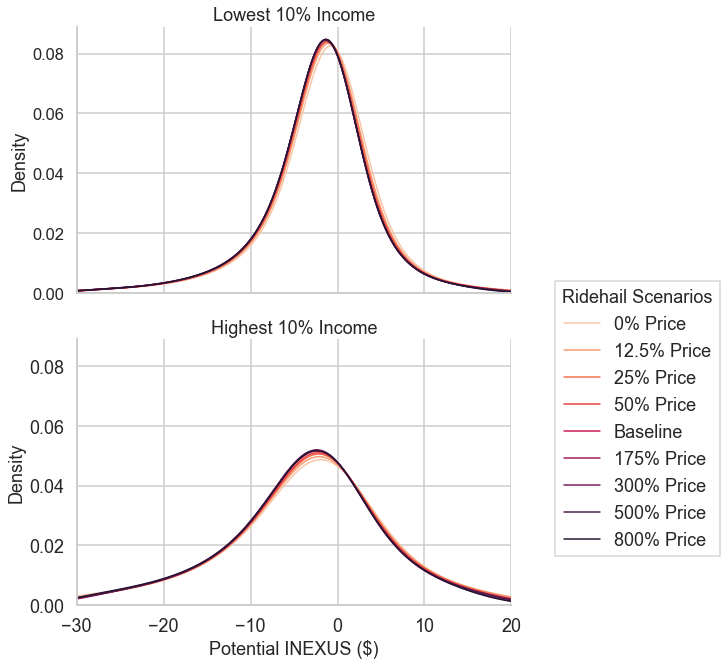

In [295]:
import mpldatacursor
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data
sns.set_context('talk')
sns.set_style("whitegrid", {'gridcolor': 'grainsboro'})
grid = sns.FacetGrid(plot_inc.loc[(plot_inc['income_deciles'] == '1stD')|
                                    (plot_inc['income_deciles'] == '10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-30,20))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
mpldatacursor.datacursor()

#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')

In [296]:
plot_inc.groupby(['income_deciles', 'lever_position_price'])['Potential_INEXUS_in_dollar_2023'].describe()

count      mean      std  \
income_deciles lever_position_price                                    
10thD          0.000000             206956.000000 -3.582369 9.353089   
               0.125000             207343.000000 -3.331565 9.042779   
               0.250000             207539.000000 -3.513692 8.833170   
               0.500000             207388.000000 -3.681283 8.781006   
               1.000000             207664.000000 -3.615435 8.720256   
               1.750000             207927.000000 -3.804409 8.680660   
               3.000000             207739.000000 -3.985587 8.618953   
               5.000000             207693.000000 -3.766072 8.672024   
               8.000000             207612.000000 -4.014108 8.635812   
1stD           0.000000             225817.000000 -1.779098 6.358333   
               0.125000             229381.000000 -1.930714 6.229729   
               0.250000             230388.000000 -2.076045 6.148606   
               0.500000             230601.000000 -2.207826 6.158987   
               1.000000             231399.000000 -2.229829 6.101138   
               1.750000             231369.000000 -2.331247 6.120171   
               3.000000             231831.000000 -2.376640 6.115486   
               5.000000             231762.000000 -2.320232 6.114689   
               8.000000             231594.000000 -2.361759 6.081588   
2ndD           0.000000             221707.000000 -2.245157 7.419103   
               0.125000             223304.000000 -2.276485 7.200322   
               0.250000             223712.000000 -2.426414 7.048450   
               0.500000             224237.000000 -2.581197 7.084340   
               1.000000             224844.000000 -2.591460 7.011604   
               1.750000             224797.000000 -2.730172 6.990376   
               3.000000             224599.000000 -2.815406 7.006033   
               5.000000             224585.000000 -2.712377 7.038075   
               8.000000             224189.000000 -2.788307 6.964109   
3rdD           0.000000             217609.000000 -2.540832 7.865417   
               0.125000             219637.000000 -2.515310 7.643169   
               0.250000             220274.000000 -2.662668 7.490619   
               0.500000             220839.000000 -2.807448 7.470535   
               1.000000             221127.000000 -2.790200 7.437913   
               1.750000             221139.000000 -2.913126 7.401626   
               3.000000             221266.000000 -3.015914 7.378033   
               5.000000             221345.000000 -2.908905 7.420111   
               8.000000             221318.000000 -3.035684 7.363958   
4thD           0.000000             208748.000000 -2.899141 8.412150   
               0.125000             209930.000000 -2.803795 8.154124   
               0.250000             210178.000000 -2.966452 8.002738   
               0.500000             210278.000000 -3.113552 7.947169   
               1.000000             210602.000000 -3.103804 7.917751   
               1.750000             210603.000000 -3.273827 7.870263   
               3.000000             211035.000000 -3.380185 7.864986   
               5.000000             210317.000000 -3.255097 7.910652   
               8.000000             210266.000000 -3.418524 7.839968   
5thD           0.000000             214604.000000 -3.089393 8.613559   
               0.125000             219524.000000 -2.950085 8.393996   
               0.250000             220297.000000 -3.111115 8.166557   
               0.500000             216753.000000 -3.292376 8.147037   
               1.000000             220264.000000 -3.235085 8.073152   
               1.750000             220708.000000 -3.390889 8.050507   
               3.000000             220416.000000 -3.515732 7.987876   
               5.000000             220017.000000 -3.401344 8.051591   
               8.000000             220216.000000 -3.551924 7.986364   
6thD        

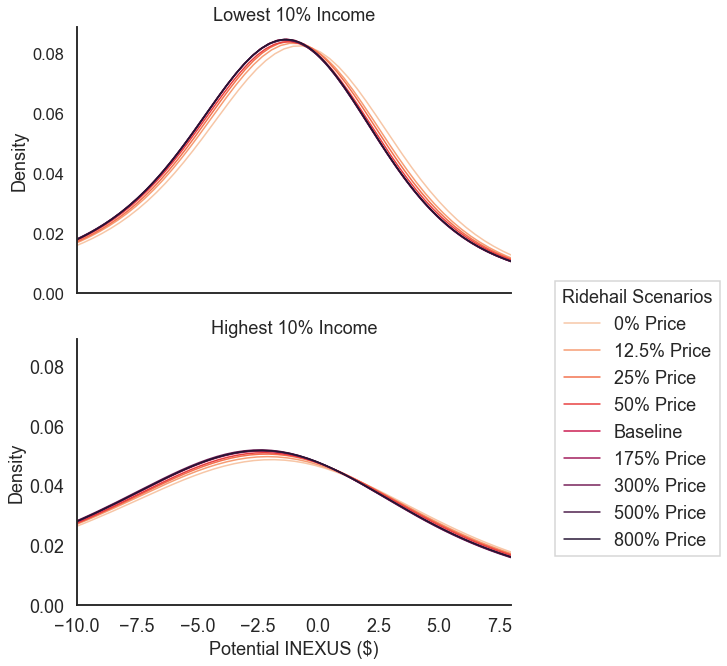

In [292]:
sns.set(rc={'figure.figsize':(20,14)}) # same mode cleaned data
sns.set_context('talk')
sns.set_style("white")
grid = sns.FacetGrid(plot_inc.loc[(plot_inc['income_deciles'] == '1stD')|
                                    (plot_inc['income_deciles'] == '10thD')], 
                     row = 'income_deciles', col_order=['10thD', '1stD'],
                     hue='lever_position_price', height=5, aspect=1.5, palette = "rocket_r", legend_out=True )
grid.map(sns.kdeplot, 'Potential_INEXUS_in_dollar_2023', bw_adjust =5, linewidth = 1.5)
#grid.set(xlim=(14, sf_stacked_rh_price['Realized_INEXUS_in_dollar'].max()), ylim=(0,0.06))
#grid.add_legend()

for ax, title in zip(grid.axes.flat, ['Lowest 10% Income','Highest 10% Income']):
    ax.set_title(title)

grid.set(xlim=(-10,8))

plt.legend(title="Ridehail Scenarios", labels = ['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'],
         fontsize='small', fancybox=False, bbox_to_anchor=(1.5, 0.7), ncol=1, frameon=True, loc = 'right', prop={'size': 18})
grid.set_ylabels('Density', size=18)
grid.set_xlabels('Potential INEXUS ($)', size=18)
ax.yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_tick_params(labelsize = 18)
# Squash down a little and add title to facetgrid    
plt.subplots_adjust(top=0.9)
#grid.fig.suptitle('Realized INEXUS in dollar across income levels in different lever positions')
#plt.savefig('potential_income_2023.svg', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')
#plt.savefig('potential_income_2023.png', dpi = 300, bbox_extra_artists=(ax.legend(['0% Price', '12.5% Price', '25% Price','50% Price','Baseline','175% Price','300% Price', '500% Price','800% Price'], bbox_to_anchor=(1.4, 0.7), ncol=1, frameon=True, loc = 'right', fontsize=18),), bbox_inches='tight')